In [1]:
import pandas as pd
import numpy as np
import os
import sys
import sqlite3
from datetime import datetime

import jupyter_black

jupyter_black.load()

from scipy.stats import skew, kurtosis, chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, Birch, OPTICS

from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors


from kneed import KneeLocator

from base64 import b64encode
from io import BytesIO

import uuid

from IPython.display import Markdown as md, display, HTML

from fastcluster import ward

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.olist import get_olist_dataframe
from lib.clean import clean

from lib.graphUtils import (
    show_pie,
    show_lines,
    show_pca_variance_graph,
    show_pca_correlation_graph,
    show_scatter_graph,
    show_cols_boxplots_by_col,
    view_clustered_heatmap,
)

pio.renderers.default = "iframe"

working_dir = "working"
if not os.path.exists(working_dir):
    os.mkdir(working_dir)

if not os.path.exists("/tmp/aggcluster_mem"):
    os.mkdir("/tmp/aggcluster_mem")

if not os.path.exists("/tmp/optics_mem"):
    os.mkdir("/tmp/optics_mem")

if not os.path.exists("/tmp/hdbscan_mem"):
    os.mkdir("/tmp/hdbscan_mem")

db_file = f"{working_dir}/olist.sqlite3"

# Lecture des fichier CSV et création du dataframe initial

<img src="../assets/olist/olist.png">

In [2]:
df = get_olist_dataframe(db_file=db_file, dir_path="../assets/olist")

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
df_original = df.copy(deep=True)

# Utilisation des colonnes r,f,m uniquement

In [5]:
df

,customer_unique_id,last_order_id,customer_state,customer_latitude,customer_longitude,nb_all_purchases,average_amount,last_timestamp,last_nb_items,last_categories,last_amount,last_expected_delivery_delay,last_effective_delivery_delay,last_freight_value,last_photos_quantity,last_payments,last_review_score,all_purchases_timestamps,all_purchases_categories,all_purchases_amount,all_purchases_payments,all_purchases_review_score,all_expected_delivery_delay,all_effective_delivery_delay,all_freight_value,all_photos_quantity
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,SP,-23.340262,-46.831085,1,129.90,2018-05-10 10:56:27,1,bed_bath_table:129.9,129.90,10.544132,6.411227,12.00,1.0,credit_card:141.9,5.0,2018-05-10 10:56:27,bed_bath_table:129.9,129.90,credit_card:141.9,5.0,10.544132,6.411227,12.00,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,SP,-23.559044,-46.788516,1,18.90,2018-05-07 11:11:27,1,health_beauty:18.9,18.90,7.533715,3.285590,8.29,1.0,credit_card:27.19,4.0,2018-05-07 11:11:27,health_beauty:18.9,18.90,credit_card:27.19,4.0,7.533715,3.285590,8.29,1.0
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,SC,-27.543010,-48.634938,1,69.00,2017-03-10 21:05:03,1,stationery:69.0,69.00,27.121493,25.731759,17.22,3.0,credit_card:86.22,3.0,2017-03-10 21:05:03,stationery:69.0,69.00,credit_card:86.22,3.0,27.121493,25.731759,17.22,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,PA,-1.312726,-48.482748,1,25.99,2017-10-12 20:29:41,1,telephony:25.99,25.99,31.146053,20.037083,17.63,5.0,credit_card:43.62,4.0,2017-10-12 20:29:41,telephony:25.99,25.99,credit_card:43.62,4.0,31.146053,20.037083,17.63,5.0
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,SP,-23.505588,-47.469820,1,180.00,2017-11-14 19:45:42,1,telephony:180.0,180.00,20.176597,13.141134,16.89,3.0,credit_card:196.89,5.0,2017-11-14 19:45:42,telephony:180.0,180.00,credit_card:196.89,5.0,20.176597,13.141134,16.89,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94985,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,PE,-8.362654,-36.562103,1,1570.00,2017-06-08 21:00:36,2,"health_beauty:890.0,health_beauty:680.0",1570.00,54.124583,27.514861,497.42,2.0,"credit_card:2067.42,credit_card:2067.42",5.0,2017-06-08 21:00:36,"health_beauty:890.0,health_beauty:680.0",1570.00,credit_card:2067.42,5.0,54.124583,27.514861,497.42,2.0
94986,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,BA,-12.217900,-38.959237,1,64.89,2017-12-10 20:07:56,1,baby:64.89,64.89,32.161157,30.097500,19.69,2.0,credit_card:84.58,4.0,2017-12-10 20:07:56,baby:64.89,64.89,credit_card:84.58,4.0,32.161157,30.097500,19.69,2.0
94987,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,MT,-11.834705,-55.508145,1,89.90,2017-02-07 15:49:16,1,auto:89.9,89.90,44.340787,14.872083,22.56,5.0,credit_card:112.46,5.0,2017-02-07 15:49:16,auto:89.9,89.90,credit_card:112.46,5.0,44.340787,14.872083,22.56,5.0
94988,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,ES,-21.126170,-41.672396,1,115.00,2018-05-02 15:17:41,1,watches_gifts:115.0,115.00,25.362720,11.858854,18.69,3.0,credit_card:133.69,5.0,2018-05-02 15:17:41,watches_gifts:115.0,115.00,credit_card:133.69,5.0,25.362720,11.858854,18.69,3.0


In [6]:
r = clean(df, use_min_max_scaler=True, use_standard_scaler=False)
df = r["data"]
scaler = r["scaler"]

featureSplitterTransformer, from_column=last_categories
featureSplitterTransformer, from_column=all_purchases_categories
featureSplitterTransformer, from_column=last_payments
featureSplitterTransformer, from_column=all_purchases_payments
last_categories
all_purchases_categories
last_payments
all_purchases_payments


In [7]:
num_cols = df.select_dtypes(include=[np.number]).columns
X_scaled = df.loc[:, num_cols]

df.head()

,f,m,r
0,0.0,0.009603,0.153527
1,0.0,0.001343,0.157676
2,0.0,0.005071,0.741355
3,0.0,0.001871,0.442600
4,0.0,0.013330,0.396957


## t-NSE

In [8]:
if os.path.exists(f"{working_dir}/X_embedded_rfm.npy"):
    X_embedded = np.load(f"{working_dir}/X_embedded_rfm.npy")
else:
    tsne = TSNE(n_components=2, random_state=0)
    X_embedded = tsne.fit_transform(X_scaled)
    np.save(f"{working_dir}/X_embedded_rfm.npy", X_embedded)

In [9]:
show_scatter_graph(x=X_embedded[:, 0], y=X_embedded[:, 1], title="Projection t-NSE")

## Clustering

### Birch

#### Evaluation

In [10]:
birch = Birch(threshold=0.01)

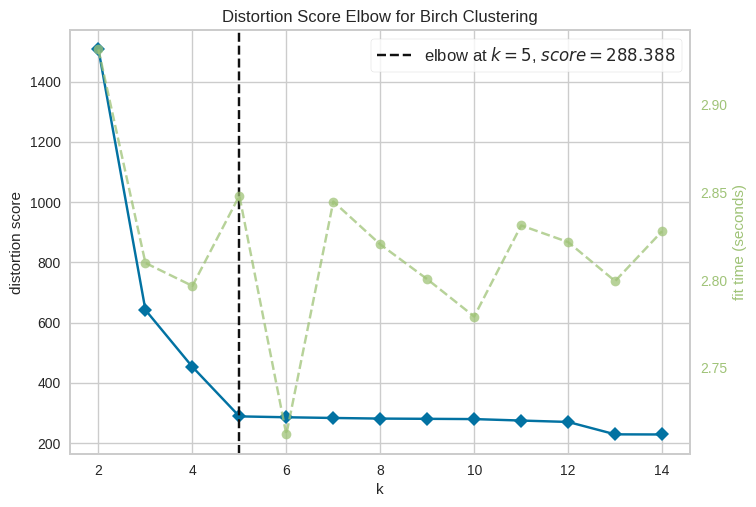

<Axes: title={'center': 'Distortion Score Elbow for Birch Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
visualizer = KElbowVisualizer(birch, k=(2, 15))

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

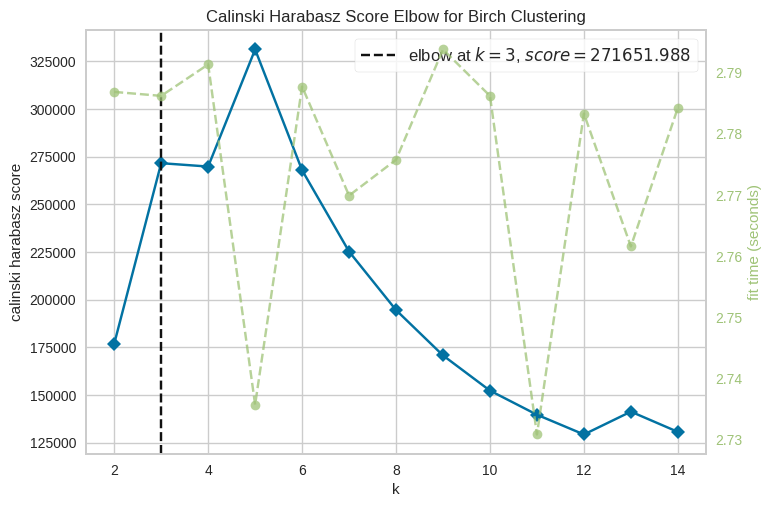

<Axes: title={'center': 'Calinski Harabasz Score Elbow for Birch Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [12]:
visualizer = KElbowVisualizer(birch, k=(2, 15), metric="calinski_harabasz")

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

Le nombre optimal de clusters pour l' algorithme Birch est 5.

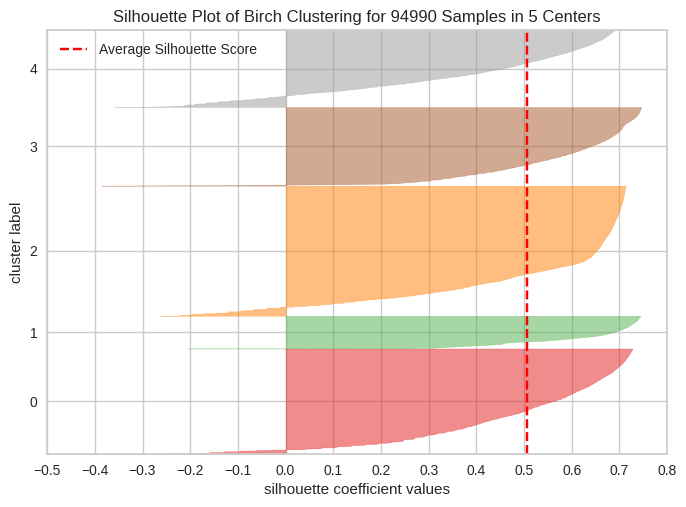

<Axes: title={'center': 'Silhouette Plot of Birch Clustering for 94990 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [13]:
birch = Birch(threshold=0.01, n_clusters=5)
visualizer = SilhouetteVisualizer(birch)

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

#### Projection t-NSE

In [14]:
X_scaled.reset_index(drop=True, inplace=True)
X_scaled["score"] = birch.labels_.astype(str)
show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_scaled["score"],
    title="Projection t-NSE selon Birch n_clusters=5, r+f+m",
)

#### Interprétation

In [15]:
view_clustered_heatmap(X_scaled, birch, scaler, title="Birch, k=5, r+f+m", height=500)

In [16]:
df2 = df.copy(deep=True)
df2 = pd.DataFrame(
    scaler.inverse_transform(X_scaled.loc[:, ["f", "m", "r"]]), columns=["f", "m", "r"]
)

show_cols_boxplots_by_col(
    df2,
    ["r", "f", "m"],
    birch.labels_.astype(str),
    title="Birch, k=5, r+f+m",
    orient="v",
    w=1500,
    h=600,
)

On voit que le clustering avec Birch a été fait autour de r:
- cluster 0 avec une récence médiane à 190
- cluster 1 avec une récence médiane à 533
- cluster 2 avec une récence médiane à 70
- cluster 3 avec une récence médiane à 282
- cluster 4 avec une récence médiane à 408

In [17]:
X_scaled.drop(columns="score", inplace=True)

### KMeans

#### Evaluation

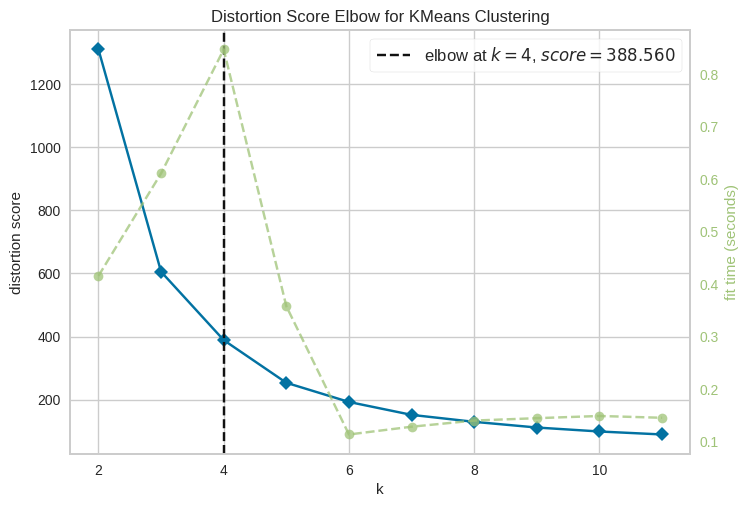

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
kmeans = KMeans(init="k-means++", random_state=0, n_init="auto")

visualizer = KElbowVisualizer(kmeans, k=(2, 12))

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

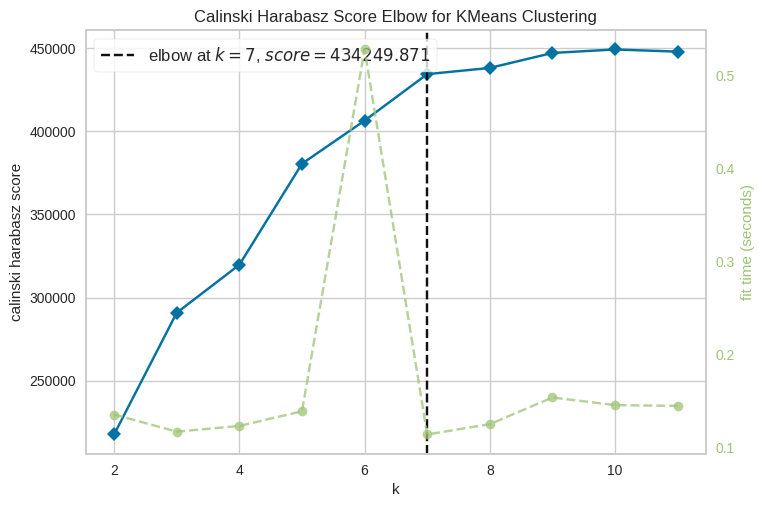

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [19]:
visualizer = KElbowVisualizer(kmeans, k=(2, 12), metric="calinski_harabasz")

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

On constate un point optimal avec n_clusters=4

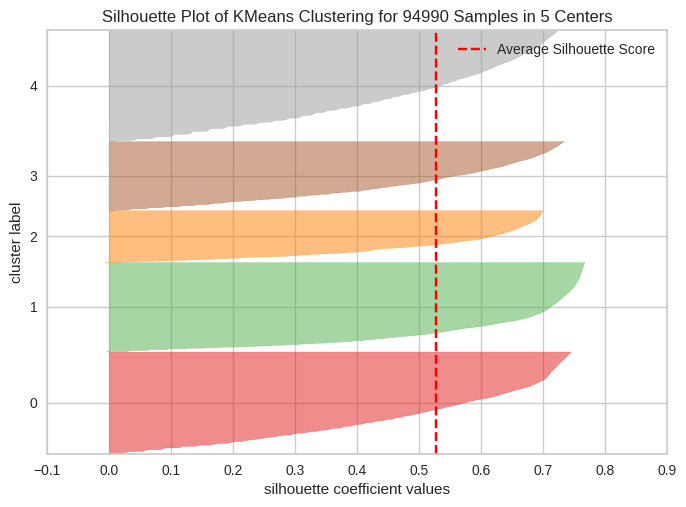

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 94990 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [20]:
kmeans = KMeans(n_clusters=5, init="k-means++", random_state=0, n_init="auto")
visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

#### Projection t-NSE

In [21]:
X_scaled.reset_index(drop=True, inplace=True)
X_scaled["kmeans"] = kmeans.labels_.astype(str)
show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_scaled["kmeans"],
    title="Projection t-NSE selon KMeans n_clusters=5, r+f+m",
)

#### Interpretation

In [22]:
view_clustered_heatmap(X_scaled, kmeans, scaler, title="KMeans, k=5, r,f,m", height=500)

In [23]:
df2 = df.copy(deep=True)
df2 = pd.DataFrame(
    scaler.inverse_transform(X_scaled.loc[:, ["f", "m", "r"]]), columns=["f", "m", "r"]
)

show_cols_boxplots_by_col(
    df2,
    ["r", "f", "m"],
    kmeans.labels_.astype(str),
    title="Kmeans, k=5, r+f+m",
    orient="v",
    w=1500,
    h=600,
)

Comme pour Birch, le clustering en Kmeans se fait via r.

Par contre, le clustering est plus net qu'avec Birch, les limites des clusters sont mieux définies:
- cluster 1: récence inférieure à 101
- cluster 4: récence entre 102 et 208
- cluster 0: récence entre 209 et 323
- cluster 3: récence entre 324 et 448
- cluster 3: supérieure à 449

In [24]:
X_scaled.drop(columns=["kmeans"], inplace=True)

### OPTICS+DBSCAN
#### Evaluation

In [25]:
X_scaled.shape

(94990, 3)

In [26]:
min_points = 2 * X_scaled.shape[1]

neighbors = NearestNeighbors(n_neighbors=min_points)
neighbors_fit = neighbors.fit(X_scaled)

distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 4]

kneedle = KneeLocator(
    x=range(1, len(distances) + 1),
    y=distances,
    S=1.0,
    curve="concave",
    direction="increasing",
    online=True,
)
knee_y = kneedle.knee_y
print(knee_y)

0.0616085427586643


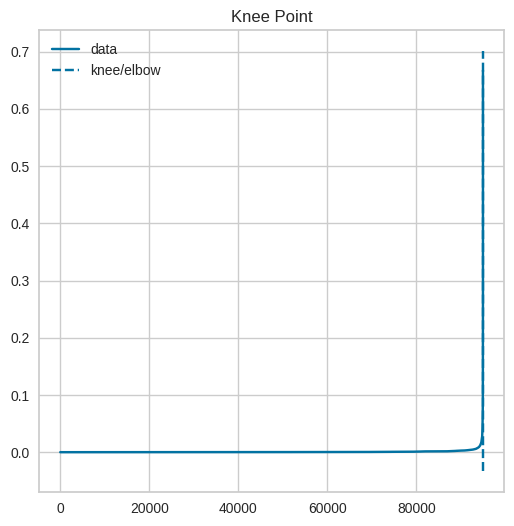

In [27]:
kneedle.plot_knee()
plt.show()

In [28]:
mem_dir = f"/tmp/optics_mem/{uuid.uuid1()}"
os.mkdir(mem_dir)

In [29]:
X_scaled.reset_index(drop=True, inplace=True)
if "optics" in X_scaled:
    X_scaled.drop(columns="optics", inplace=True)
for i in range(5, 21):
    optics = OPTICS(
        max_eps=knee_y * 2,
        min_samples=X_scaled.shape[1] * 2,
        cluster_method="dbscan",
        eps=min(i * knee_y / 20, knee_y),
        n_jobs=-1,
        memory=mem_dir,
    ).fit(X_scaled)
    X_scaled["optics"] = optics.labels_.astype(str)
    show_pie(
        X_scaled, "optics", w=600, h=400, title=f"""eps={min(i * knee_y/20, knee_y)}"""
    )
    X_scaled.drop(columns="optics", inplace=True)

Aucune clusterisation ne donne de partition interessante

# Etude sur r,f,m review, weekday

In [30]:
df = pd.read_parquet(f"{working_dir}/olist.parquet")

In [31]:
df.head()

,customer_unique_id,last_order_id,customer_state,customer_latitude,customer_longitude,nb_all_purchases,average_amount,last_timestamp,last_nb_items,last_categories,last_amount,last_expected_delivery_delay,last_effective_delivery_delay,last_freight_value,last_photos_quantity,last_payments,last_review_score,all_purchases_timestamps,all_purchases_categories,all_purchases_amount,all_purchases_payments,all_purchases_review_score,all_expected_delivery_delay,all_effective_delivery_delay,all_freight_value,all_photos_quantity
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,SP,-23.340262,-46.831085,1,129.90,2018-05-10 10:56:27,1,bed_bath_table:129.9,129.90,10.544132,6.411227,12.00,1.0,credit_card:141.9,5.0,2018-05-10 10:56:27,bed_bath_table:129.9,129.90,credit_card:141.9,5.0,10.544132,6.411227,12.00,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,SP,-23.559044,-46.788516,1,18.90,2018-05-07 11:11:27,1,health_beauty:18.9,18.90,7.533715,3.285590,8.29,1.0,credit_card:27.19,4.0,2018-05-07 11:11:27,health_beauty:18.9,18.90,credit_card:27.19,4.0,7.533715,3.285590,8.29,1.0
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,SC,-27.543010,-48.634938,1,69.00,2017-03-10 21:05:03,1,stationery:69.0,69.00,27.121493,25.731759,17.22,3.0,credit_card:86.22,3.0,2017-03-10 21:05:03,stationery:69.0,69.00,credit_card:86.22,3.0,27.121493,25.731759,17.22,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,PA,-1.312726,-48.482748,1,25.99,2017-10-12 20:29:41,1,telephony:25.99,25.99,31.146053,20.037083,17.63,5.0,credit_card:43.62,4.0,2017-10-12 20:29:41,telephony:25.99,25.99,credit_card:43.62,4.0,31.146053,20.037083,17.63,5.0
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,SP,-23.505588,-47.469820,1,180.00,2017-11-14 19:45:42,1,telephony:180.0,180.00,20.176597,13.141134,16.89,3.0,credit_card:196.89,5.0,2017-11-14 19:45:42,telephony:180.0,180.00,credit_card:196.89,5.0,20.176597,13.141134,16.89,3.0


In [32]:
r = clean(df, use_features=["review", "weekday"])
df = r["data"]
scaler = r["scaler"]

featureSplitterTransformer, from_column=last_categories
featureSplitterTransformer, from_column=all_purchases_categories
featureSplitterTransformer, from_column=last_payments
featureSplitterTransformer, from_column=all_purchases_payments
last_categories
all_purchases_categories
last_payments
all_purchases_payments


In [33]:
num_cols = df.select_dtypes(include=[np.number]).columns

X_scaled = df.loc[:, num_cols].reset_index(drop=True)

## t-NSE

In [34]:
if os.path.exists(f"{working_dir}/X_embedded_rfm_review_weekday.npy"):
    X_embedded = np.load(f"{working_dir}/X_embedded_rfm_review_weekday.npy")
else:
    tsne = TSNE(n_components=2, random_state=0)
    X_embedded = tsne.fit_transform(X_scaled)
    np.save(f"{working_dir}/X_embedded_rfm_review_weekday.npy", X_embedded)

show_scatter_graph(
    X_embedded[:, 0],
    X_embedded[:, 1],
    title="Représentation t-NSE avec r,f,m, weekday et review_score",
    w=1300,
)

## Clustering
### Birch
#### Evaluation

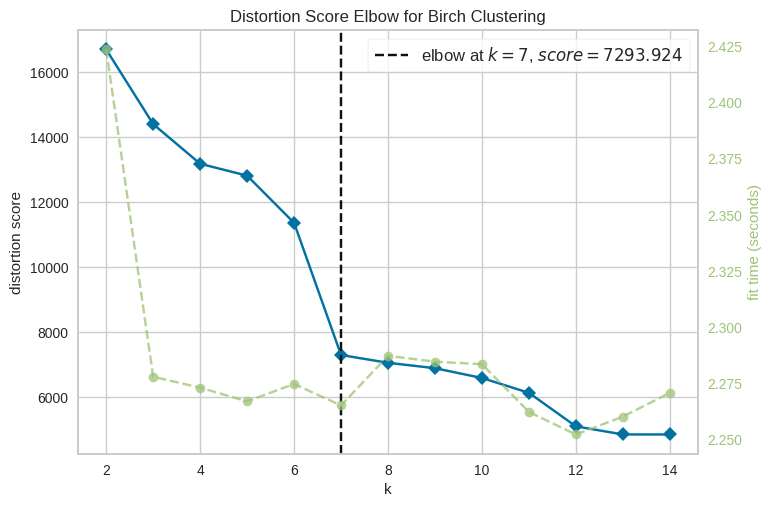

<Axes: title={'center': 'Distortion Score Elbow for Birch Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
birch = Birch(threshold=0.1)
visualizer = KElbowVisualizer(birch, k=(2, 15))

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

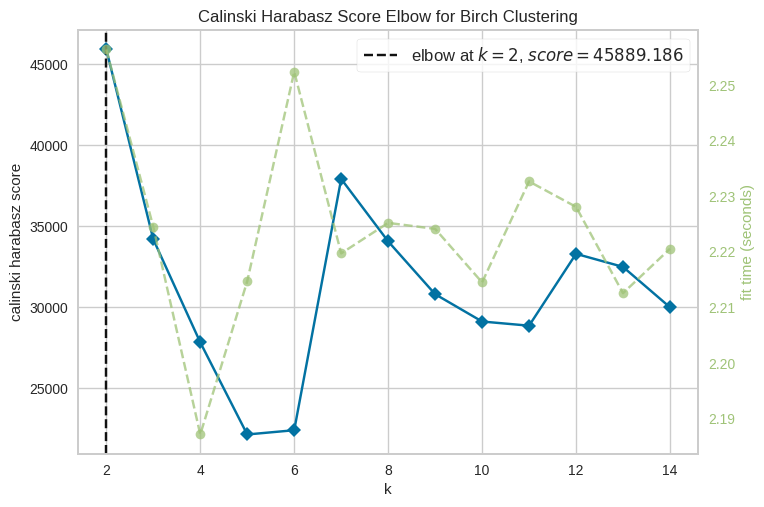

<Axes: title={'center': 'Calinski Harabasz Score Elbow for Birch Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [36]:
visualizer = KElbowVisualizer(birch, k=(2, 15), metric="calinski_harabasz")

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

##### n_clusters optimal : 5

In [37]:
birch = Birch(threshold=0.1, n_clusters=5)

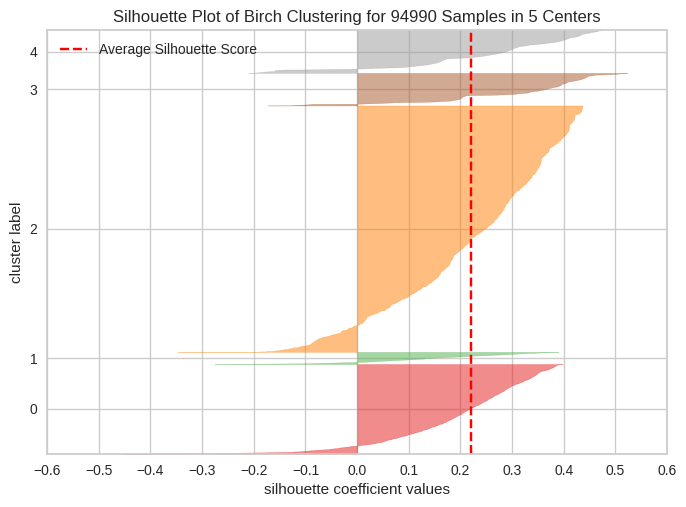

<Axes: title={'center': 'Silhouette Plot of Birch Clustering for 94990 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [38]:
visualizer = SilhouetteVisualizer(birch)

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

In [39]:
X_scaled["birch"] = birch.labels_.astype(str)

#### Projection t-NSE

In [40]:
show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_scaled["birch"].astype(str),
    title="Projection t-NSE selon Birch avec n_clusters=5, avec r+f+m+weekday+review_score",
)

#### Interprétation

In [41]:
view_clustered_heatmap(
    X_scaled, birch, scaler, title="Birch, k=5, r+f+m+weekday+review_score", height=500
)

In [42]:
df2 = df.copy(deep=True)
df2 = pd.DataFrame(
    scaler.inverse_transform(X_scaled.loc[:, num_cols]), columns=num_cols
)
df2.reset_index(drop=True, inplace=True)
df2["birch"] = birch.labels_.astype(str)

show_cols_boxplots_by_col(
    df2,
    num_cols,
    "birch",
    title="Birch avec n_clusters=5 pour r+f+m+weekday+review_score",
    orient="v",
    h=1500,
    w=1000,
)

On distingue des clusters de manière floue:
- cluster 4: les clients qui achètent du lundi au vendredi et qui laissent des review scores jusqu'à 3.5 en moyenne
- cluster 3: les clients qui achètent du mercredi au dimanche et qui laissent des review scores jusqu'à 3.5 en moyenne et qui one une récence <= 425 j
- cluster 1: les clients qui laissent des review scores jusqu'à 3.5 en moyenne et qui on une récence >= 309 jours
- cluster 2: les clients qui laissent des review scores très élevés et ont une récence <= 496j
- cluster 3: les clients qui laissent des review scores très élevés et ont une récence >= 203

In [43]:
X_scaled.drop(columns=["birch"], inplace=True)

### KMeans
#### Evaluation

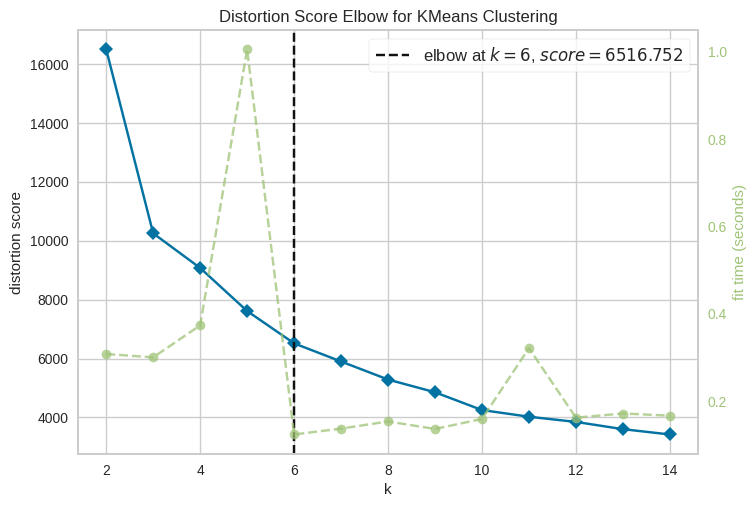

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2, 15))

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

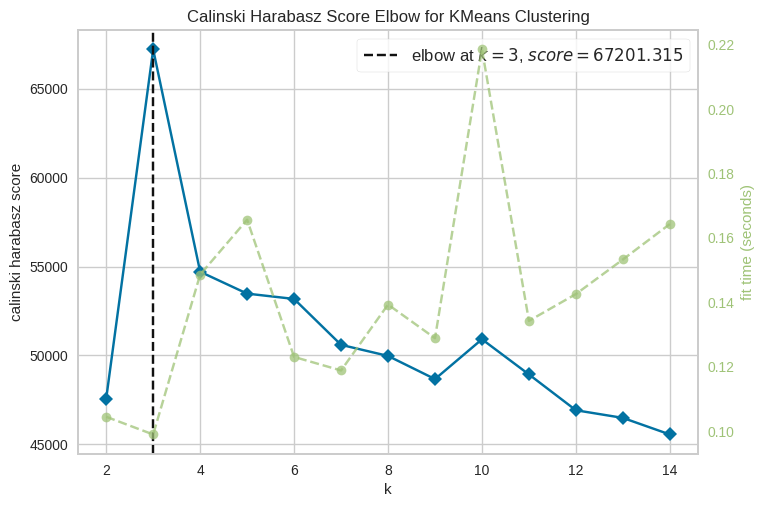

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [45]:
visualizer = KElbowVisualizer(km, k=(2, 15), metric="calinski_harabasz")

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

Nous avons n_cluster optimal = 5

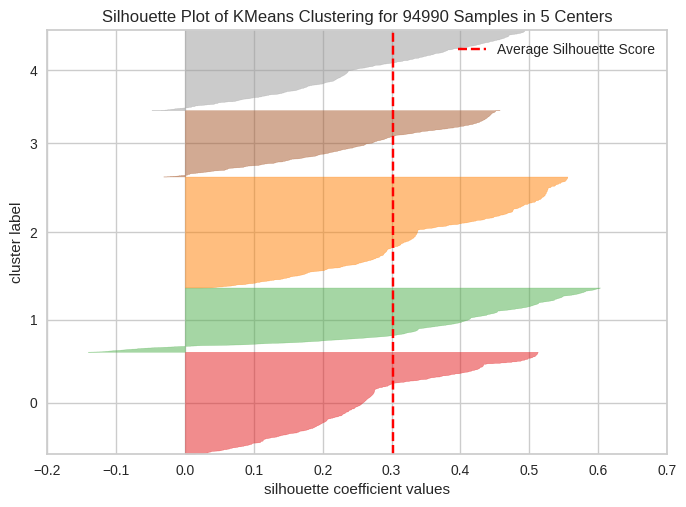

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 94990 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [46]:
km = KMeans(init="k-means++", n_clusters=5, random_state=0, n_init="auto")
visualizer = SilhouetteVisualizer(km)

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

In [47]:
X_scaled["km"] = km.labels_.astype(str)

#### Projection t-SNE

In [48]:
show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_scaled["km"],
    title="Projection t-NSE selon KMeans avec n_clusters=4, avec r,f,m, weekday et review_score",
)

#### Interprétation

In [49]:
view_clustered_heatmap(
    X_scaled,
    kmeans,
    scaler,
    title="Kmeans, k=5, r+f+m+weekday+review_score",
    height=500,
)

In [50]:
df2 = df.copy(deep=True)
df2 = pd.DataFrame(
    scaler.inverse_transform(X_scaled.loc[:, num_cols]), columns=num_cols
)
df2.reset_index(drop=True, inplace=True)
df2["kmeans"] = kmeans.labels_.astype(str)

show_cols_boxplots_by_col(
    df2,
    num_cols,
    "kmeans",
    title="Kmeans avec n_clusters=5 pour r+f+m+weekday+review_score",
    orient="v",
    h=1500,
    w=1000,
)

Kmeans a groupé selon les valeurs de r:
- cluster 1: r<=101
- cluster 4: 102<=r<=208
- cluster 0: 209<=r<=323
- cluster 3: 324<=r<=448
- cluster 2: 449<=r

In [51]:
X_scaled.drop(columns="km", inplace=True)

### OPTICS+DBScan
#### Evaluation

In [52]:
min_points = 2 * X_scaled.shape[1]

neighbors = NearestNeighbors(n_neighbors=min_points)
neighbors_fit = neighbors.fit(X_scaled)

distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 4]

kneedle = KneeLocator(
    x=range(1, len(distances) + 1),
    y=distances,
    S=1.0,
    curve="concave",
    direction="increasing",
    online=True,
)
knee_y = kneedle.knee_y
print(knee_y)

0.16883348671437995


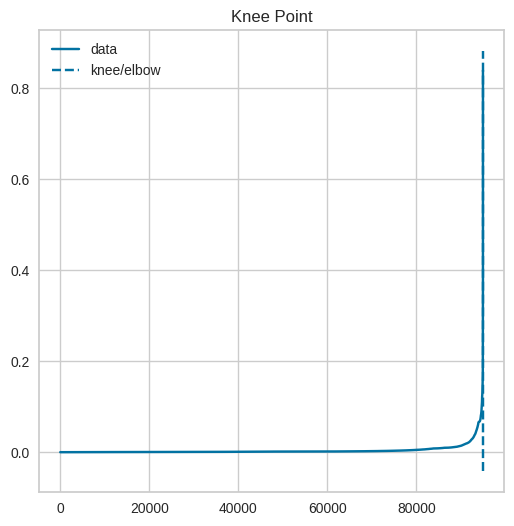

In [53]:
kneedle.plot_knee()
plt.show()

In [54]:
mem_dir = f"/tmp/optics_mem/{uuid.uuid1()}"
os.mkdir(mem_dir)

In [55]:
if "optics" in X_scaled.columns:
    X_scaled.drop(columns="optics", inplace=True)

for i in range(5, 21):
    optics = OPTICS(
        max_eps=knee_y,
        min_samples=X_scaled.shape[1] * 2,
        cluster_method="dbscan",
        eps=min(knee_y, knee_y * i / 20),
        n_jobs=-1,
        memory=mem_dir,
    ).fit(X_scaled)
    print(f"""eps={min(i * knee_y/20, knee_y)} ; labels={set(optics.labels_)}""")

eps=0.04220837167859499 ; labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, -1}
eps=0.050650046014313985 ; labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, -1}
eps=0.05909172035003298 ; labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, -1}
eps=0.06753339468575198 ; labels={0, 1, 2, 

In [56]:
optics = OPTICS(
    max_eps=knee_y,
    min_samples=X_scaled.shape[1] * 2,
    cluster_method="dbscan",
    eps=0.1351284235339067,
    n_jobs=-1,
    memory=mem_dir,
).fit(X_scaled)

In [57]:
X_scaled.reset_index(drop=True, inplace=True)
X_scaled["optics"] = optics.labels_.astype(str)

show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_scaled["optics"],
    title="Projection t-NSE selon OPTICS+DBSCAN, avec r,f,m, weekday et review_score",
)

#### Interprétation

In [58]:
view_clustered_heatmap(
    X_scaled,
    optics,
    scaler,
    title="OPTICS+DBSCAN, avec r,f,m,weekday,review_score",
    height=1000,
)

In [59]:
df2 = df.copy(deep=True)
df2 = pd.DataFrame(
    scaler.inverse_transform(X_scaled.loc[:, num_cols]), columns=num_cols
)
df2.reset_index(drop=True, inplace=True)
df2["optics"] = optics.labels_.astype(str)

show_cols_boxplots_by_col(
    df2,
    num_cols,
    "optics",
    title="OPTICS+DBSCAN, avec r,f,m,weekday,review_score",
    orient="v",
    h=1500,
    w=1000,
)

- Cluster 10: clients du lundi avec all_purchases_review_score>1
- Cluster 11: clients du lundi avec all_purchases_review_score=1
- Cluster 8: clients du mardi avec all_purchases_review_score >1
- Cluster 9: clients du mardi avec all_purchases_review_score=1
- Cluster 7: clients du mercredi
- Cluster 0: clients du jeudi avec all_purchases_review_score>=1.66
- Cluster 1: clients du jeudi avec all_purchases_review_score<1.66
- Cluster 2: clients du vendredi avec all_purchases_review_score>=1.5
- Cluster 3: clients du vendredi avec all_purchases_review_score<=1.33 et récence <= 592j
- Cluster 4: clients du vendredi avec all_purchases_review_score<=1.33 et récence >592j
- Cluster 5: clients du samedi avec all_purchases_review_score>1
- Cluster 6: clients du samedi avec all_purchases_review_score=1
- Cluster 12: clients du dimanche


In [60]:
X_scaled.drop(columns=["optics"], inplace=True)

# Etude sur r,f,m review, weekday, delivery, freight_value, photos_quantity


In [61]:
df = pd.read_parquet(f"{working_dir}/olist.parquet")

r = clean(
    df,
    use_features=["review", "weekday", "delivery", "freight_value", "photos_quantity"],
)
df = r["data"]
scaler = r["scaler"]

num_cols = df.select_dtypes(include=[np.number]).columns

X_scaled = df.loc[:, num_cols]

featureSplitterTransformer, from_column=last_categories
featureSplitterTransformer, from_column=all_purchases_categories
featureSplitterTransformer, from_column=last_payments
featureSplitterTransformer, from_column=all_purchases_payments
last_categories
all_purchases_categories
last_payments
all_purchases_payments


## t-NSE

In [62]:
if os.path.exists(
    f"{working_dir}/X_embedded_rfm_review_weekday_delivery_freight_value_photos_quantity.npy"
):
    X_embedded = np.load(
        f"{working_dir}/X_embedded_rfm_review_weekday_delivery_freight_value_photos_quantity.npy"
    )
else:
    tsne = TSNE(n_components=2, random_state=0)
    X_embedded = tsne.fit_transform(X_scaled)
    np.save(
        f"{working_dir}/X_embedded_rfm_review_weekday_delivery_freight_value_photos_quantity.npy",
        X_embedded,
    )

show_scatter_graph(
    X_embedded[:, 0],
    X_embedded[:, 1],
    title="Représentation t-NSE avec r,f,m review, weekday, delivery, freight_value, photos_quantity",
    w=1300,
)

## Clustering
### Birch
#### Evaluation

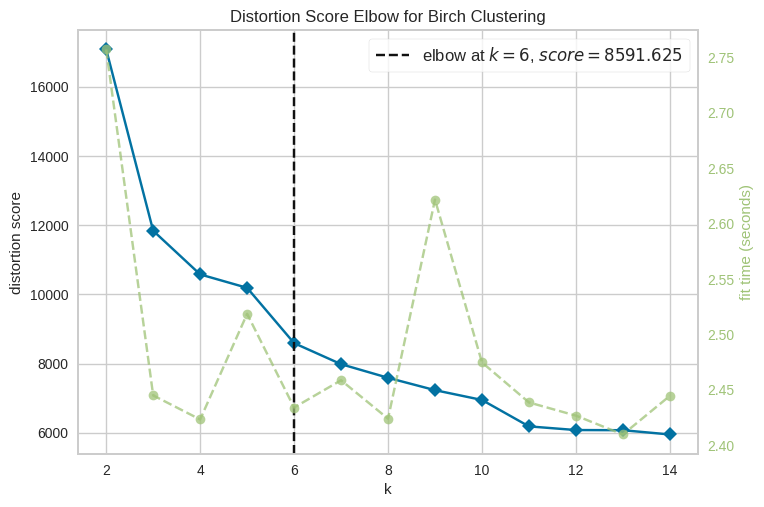

<Axes: title={'center': 'Distortion Score Elbow for Birch Clustering'}, xlabel='k', ylabel='distortion score'>

In [63]:
birch = Birch(threshold=0.1)
visualizer = KElbowVisualizer(birch, k=(2, 15))

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

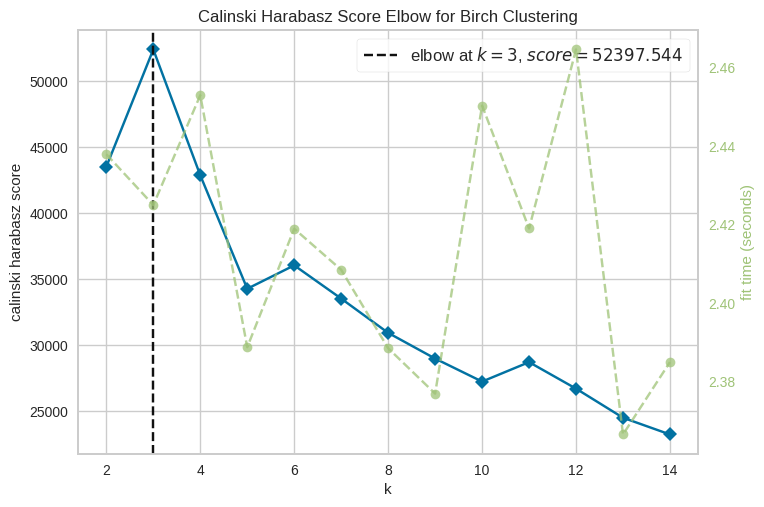

<Axes: title={'center': 'Calinski Harabasz Score Elbow for Birch Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [64]:
visualizer = KElbowVisualizer(birch, k=(2, 15), metric="calinski_harabasz")

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

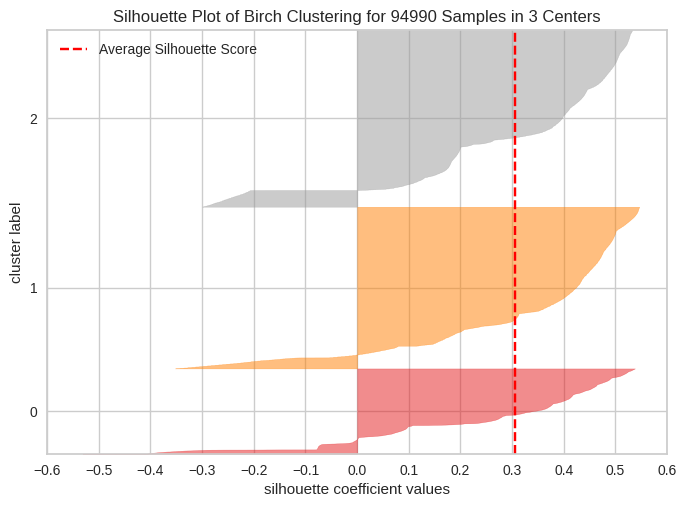

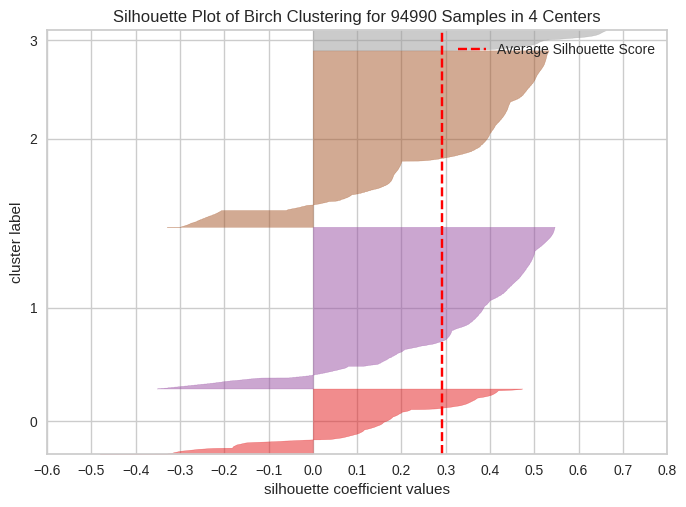

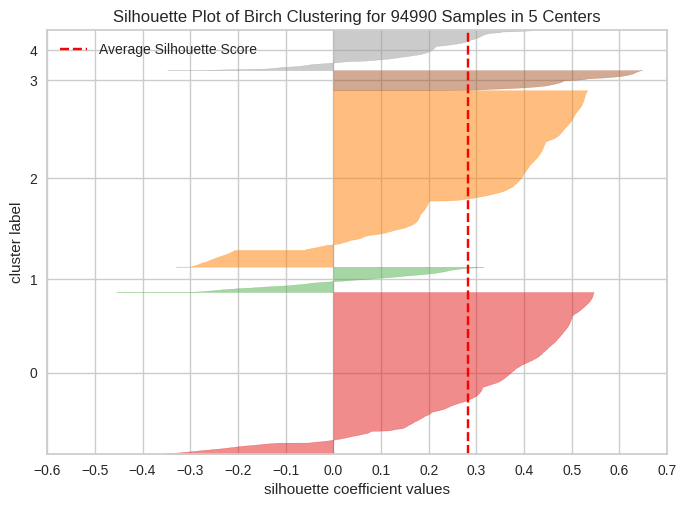

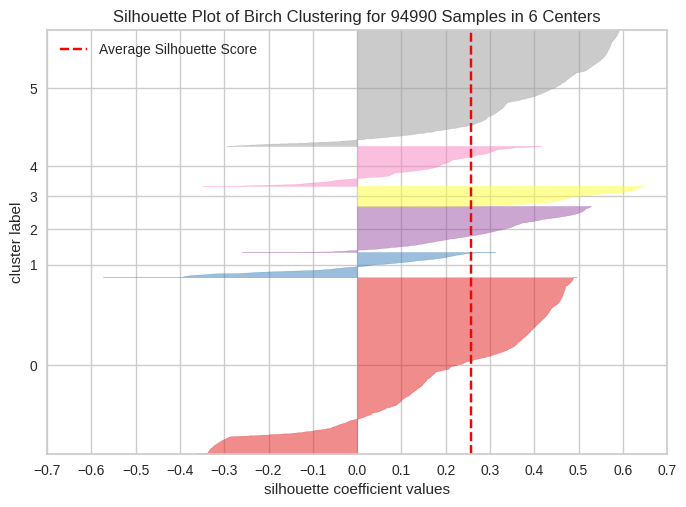

In [65]:
for n_clusters in range(3, 7):
    birch = Birch(threshold=0.1, n_clusters=n_clusters)

    visualizer = SilhouetteVisualizer(birch)

    visualizer.fit(X_scaled)  # Fit the data to the visualizer
    visualizer.poof()  # Draw/show/poof the data

In [66]:
birch = Birch(threshold=0.1, n_clusters=5)
birch.fit(X_scaled)

Birch(n_clusters=5, threshold=0.1)

#### Projection t-SNE

In [67]:
X_scaled.reset_index(drop=True, inplace=True)
X_scaled["birch"] = birch.labels_.astype(str)

show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_scaled["birch"],
    title="Projection t-NSE selon Birch, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity",
)

#### Interprétation

In [68]:
view_clustered_heatmap(
    X_scaled,
    birch,
    scaler,
    title="Birch, k=5, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity",
    height=500,
)

In [69]:
df2 = df.copy(deep=True)
df2 = pd.DataFrame(
    scaler.inverse_transform(X_scaled.loc[:, num_cols]), columns=num_cols
)
df2.reset_index(drop=True, inplace=True)
df2["birch"] = birch.labels_.astype(str)

show_cols_boxplots_by_col(
    df2,
    num_cols,
    "birch",
    title="Birch, k=5, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity",
    orient="v",
    h=1500,
    w=1000,
)

Aucune interpretation exploitable 

In [70]:
X_scaled.drop(columns="birch", inplace=True)

### KMeans
#### Evaluation

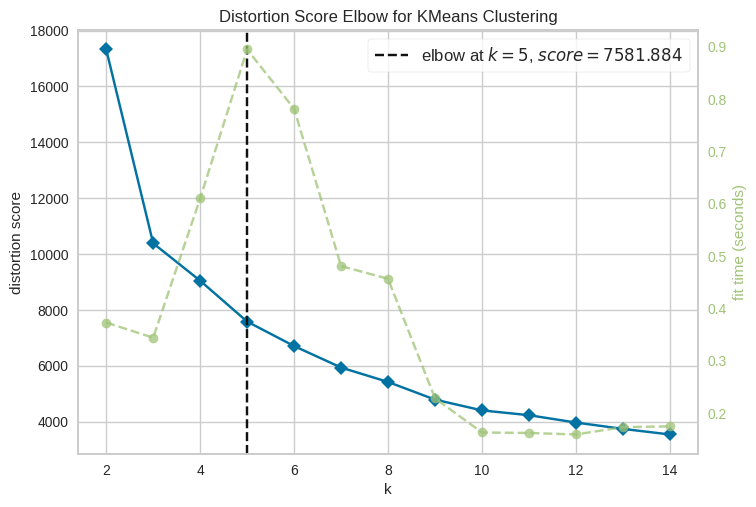

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [71]:
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2, 15))

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

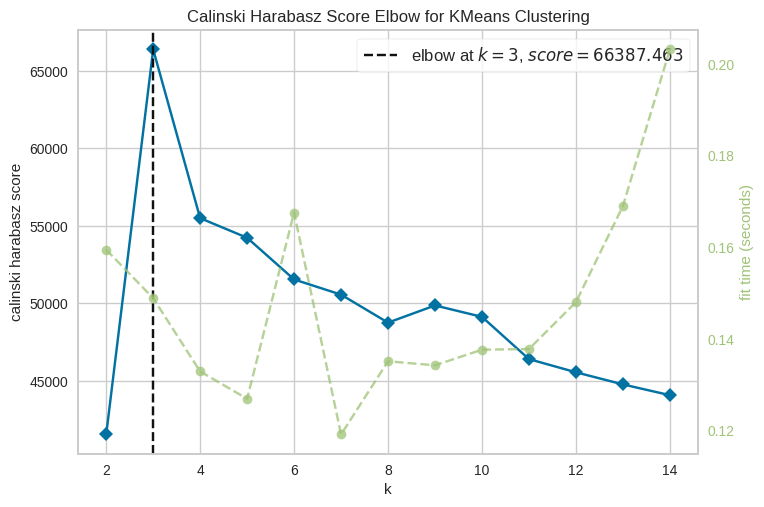

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [72]:
visualizer = KElbowVisualizer(km, k=(2, 15), metric="calinski_harabasz")

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

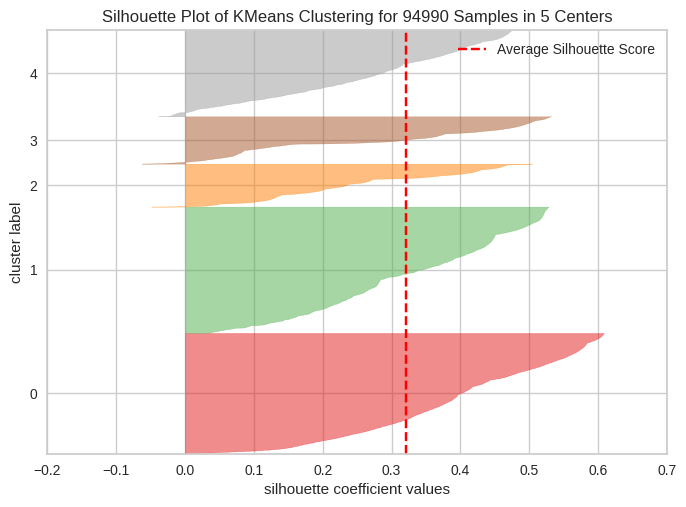

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 94990 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [73]:
km = KMeans(init="k-means++", random_state=0, n_init="auto", n_clusters=5)
visualizer = SilhouetteVisualizer(km)

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

n_clusters=5

#### Projection t-SNE

In [74]:
X_scaled["kmeans"] = km.labels_.astype(str)
X_scaled.reset_index(drop=True, inplace=True)
show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_scaled["kmeans"],
    title="Projection t-NSE selon KMeans avec n_clusters=5, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity",
)

#### Interprétation

In [75]:
view_clustered_heatmap(
    X_scaled,
    km,
    scaler,
    title="KMeans avec n_clusters=5, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity",
    height=500,
)

In [76]:
df2 = df.copy(deep=True)
df2 = pd.DataFrame(
    scaler.inverse_transform(X_scaled.loc[:, num_cols]), columns=num_cols
)
df2.reset_index(drop=True, inplace=True)
df2["kmeans"] = km.labels_.astype(str)

show_cols_boxplots_by_col(
    df2,
    num_cols,
    "kmeans",
    title="Kmeans, k=5, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity",
    orient="v",
    h=1500,
    w=1000,
)

On distingue de manière floue:
- Cluster 1: les clients qui ont une récence inférieure à 268, qui achètent du lundi au jeudi, et qui laissent des review_scores élevés
- Cluster 2: les clients qui achètent du jeudi au dimanche, et qui laissent un review_score inférieur à 3.4
- Cluster 0: les clients qui achètent du vendredi au dimanche et qui laissent un review_score supérieur à 3.5
- Cluster 3: les clients qui achètent du lundi au jeudi et qui laissent un vendredi inférieur à 3
- Cluster 4: les clients qui ont une récence supérieure à 256, qui achètent du lundi au vendredi, et qui laissent des review_scores supérieurs à 3

In [77]:
X_scaled.drop(columns="kmeans", inplace=True)

### OPTICS+DBScan
#### Evaluation

In [78]:
X_scaled.head()

,f,m,all_purchases_review_score,all_freight_value,all_photos_quantity,most_purchased_weekday,all_delivery_delay,r
0,0.0,0.009603,1.00,0.006323,0.000000,0.500000,0.423543,0.153527
1,0.0,0.001343,0.75,0.004368,0.000000,0.000000,0.423199,0.157676
2,0.0,0.005071,0.50,0.009074,0.015267,0.666667,0.431732,0.741355
3,0.0,0.001871,0.75,0.009290,0.030534,0.500000,0.402718,0.442600
4,0.0,0.013330,1.00,0.008900,0.015267,0.166667,0.414879,0.396957


In [79]:
min_points = 2 * X_scaled.shape[1]

neighbors = NearestNeighbors(n_neighbors=min_points)
neighbors_fit = neighbors.fit(X_scaled)

distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 4]

kneedle = KneeLocator(
    x=range(1, len(distances) + 1),
    y=distances,
    S=1.0,
    curve="concave",
    direction="increasing",
    online=True,
)
knee_y = kneedle.knee_y
print(knee_y)

0.29274904082239256


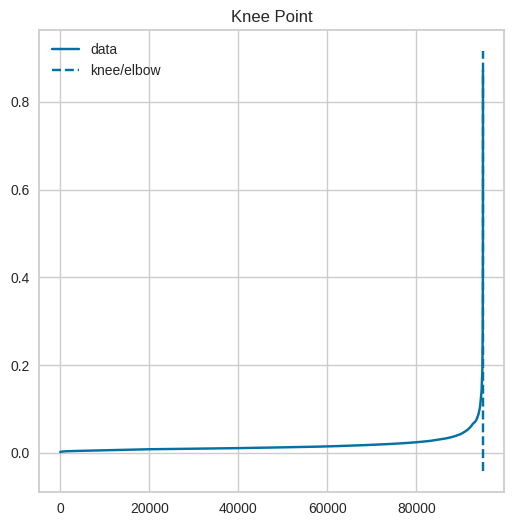

In [80]:
kneedle.plot_knee()
plt.show()

In [81]:
mem_dir = f"/tmp/optics_mem/{uuid.uuid1()}"
os.mkdir(mem_dir)

In [82]:
if "optics" in X_scaled.columns:
    X_scaled.drop(columns="optics", inplace=True)

for i in range(5, 21):
    optics = OPTICS(
        max_eps=knee_y,
        min_samples=X_scaled.shape[1] * 2,
        cluster_method="dbscan",
        eps=min(i * knee_y / 20, knee_y),
        n_jobs=-1,
        memory=mem_dir,
    ).fit(X_scaled)
    print(f"""eps={min(i * knee_y/20, knee_y)} ; labels={set(optics.labels_)}""")

eps=0.07318726020559814 ; labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, -1}
eps=0.08782471224671777 ; labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, -1}
eps=0.10246216428783739 ; labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, -1}
eps=0.11709961632895702 ; labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, -1}
eps=0.13173706837007665 ; labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}
eps=0.14637452041119628 ; labels={0, 1, 2, 3, 4, 5, 6, -1}
eps=0.1610119724523159 ; labels={0, 1, 2, 3, 4, 5, 6, -1}
eps=0.17564942449343554 ; labels={0, -1}
eps=0.1902868765345551

In [83]:
optics = OPTICS(
    max_eps=knee_y,
    min_samples=X_scaled.shape[1] * 2,
    cluster_method="dbscan",
    eps=0.137260591625861,
    n_jobs=-1,
    memory=mem_dir,
).fit(X_scaled)

#### Projection t-SNE

In [84]:
X_scaled.reset_index(drop=True, inplace=True)
X_scaled["optics"] = optics.labels_.astype(str)

show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_scaled["optics"],
    title="Projection t-NSE selon OPTICS+DBSCAN, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity",
)

#### Interprétation

In [85]:
view_clustered_heatmap(
    X_scaled,
    optics,
    scaler,
    title="OPTICS+DBSCAN, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity",
    height=1000,
)

In [86]:
df2 = df.copy(deep=True)
df2 = pd.DataFrame(
    scaler.inverse_transform(X_scaled.loc[:, num_cols]), columns=num_cols
)
df2.reset_index(drop=True, inplace=True)
df2["optics"] = optics.labels_.astype(str)

show_cols_boxplots_by_col(
    df2,
    num_cols,
    "optics",
    title="OPTICS+DBSCAN, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity",
    orient="v",
    h=1500,
    w=1000,
)

- Cluster 5: clients du lundi avec all_purchases_review_score > 1
- Cluster 6: clients du lundi avec all_purchases_review_score=1
- Cluster 4: clients du mardi avec all_purchases_review_score>1.5
- Cluster 3: clients du mardi avec all_purchases_review_score<=1.5
- Cluster 2: clients du mercredi
- Cluster 0: clients du jeudi avec all_purchases_review_score>1
- Cluster 1: clients du jeudi avec all_purchases_review_score=1
- Cluster 7: clients du vendredi avec all_purchases_review_score>=1.5
- Cluster 8: clients du vendredi avec all_purchases_review_score<1.5
- Cluster 9: clients du samedi avec all_purchases_review_score>1
- Cluster 10: clients du samedi avec all_purchases_review_score=1
- Cluster 11: clients du dimanche

# Etude sur r,f,m review, weekday, delivery, freight_value, photos_quantity, customer_location

In [87]:
df = pd.read_parquet(f"{working_dir}/olist.parquet")

r = clean(
    df,
    use_features=[
        "review",
        "weekday",
        "delivery",
        "freight_value",
        "photos_quantity",
        "customer_location",
    ],
)
df = r["data"]
scaler = r["scaler"]

df = pd.get_dummies(df)

num_cols = df.select_dtypes(include=[np.number]).columns

X_scaled = df.loc[:, num_cols]

featureSplitterTransformer, from_column=last_categories
featureSplitterTransformer, from_column=all_purchases_categories
featureSplitterTransformer, from_column=last_payments
featureSplitterTransformer, from_column=all_purchases_payments
last_categories
all_purchases_categories
last_payments
all_purchases_payments


## t-SNE

In [88]:
if os.path.exists(
    f"{working_dir}/X_embedded_rfm_review_weekday_delivery_freight_value_photos_quantity_customer_location.npy"
):
    X_embedded = np.load(
        f"{working_dir}/X_embedded_rfm_review_weekday_delivery_freight_value_photos_quantity_customer_location.npy"
    )
else:
    tsne = TSNE(n_components=2, random_state=0)
    X_embedded = tsne.fit_transform(X_scaled)
    np.save(
        f"{working_dir}/X_embedded_rfm_review_weekday_delivery_freight_value_photos_quantity_customer_location.npy",
        X_embedded,
    )

show_scatter_graph(
    X_embedded[:, 0],
    X_embedded[:, 1],
    title="Représentation t-NSE avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity,customer_location",
    w=1300,
)

## Clustering
### Birch
#### Evaluation

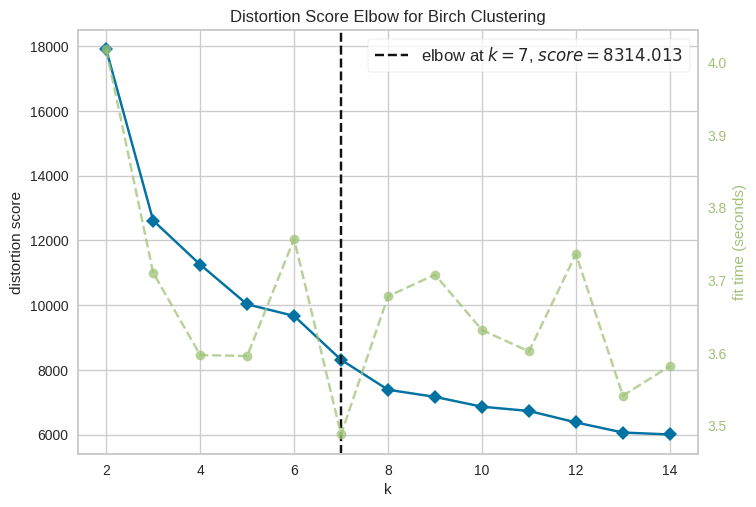

<Axes: title={'center': 'Distortion Score Elbow for Birch Clustering'}, xlabel='k', ylabel='distortion score'>

In [89]:
birch = Birch(threshold=0.1)
visualizer = KElbowVisualizer(birch, k=(2, 15))

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

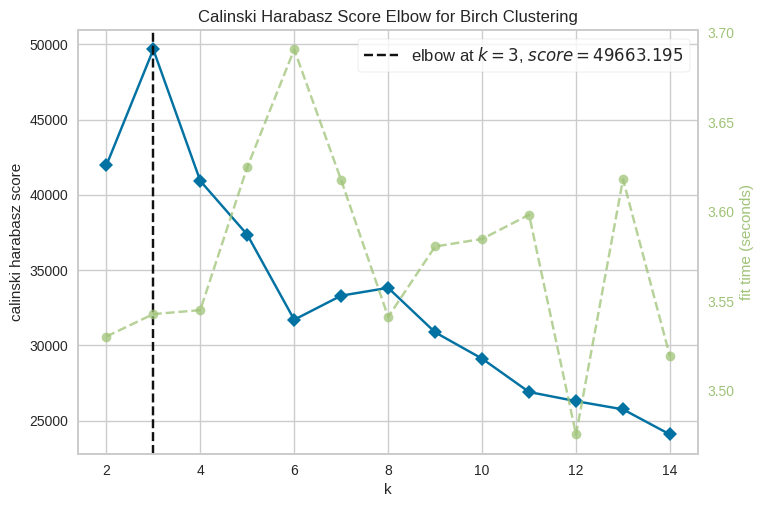

<Axes: title={'center': 'Calinski Harabasz Score Elbow for Birch Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [90]:
visualizer = KElbowVisualizer(birch, k=(2, 15), metric="calinski_harabasz")

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

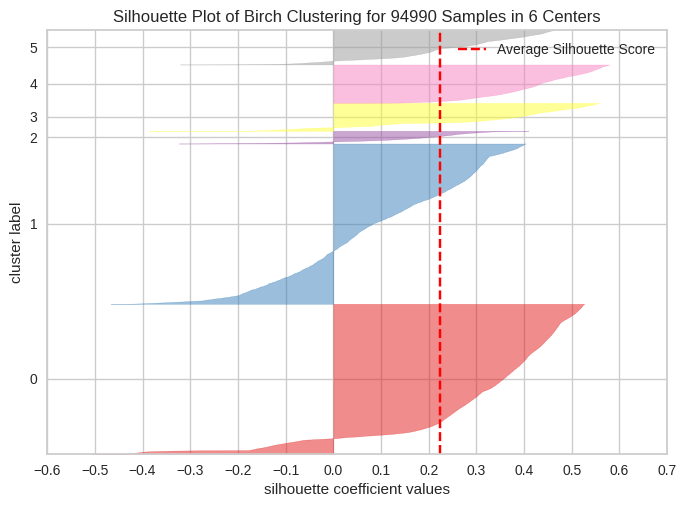

<Axes: title={'center': 'Silhouette Plot of Birch Clustering for 94990 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [91]:
birch = Birch(threshold=0.1, n_clusters=6)
visualizer = SilhouetteVisualizer(birch)

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

#### Projection t-SNE

In [92]:
X_scaled["birch"] = birch.labels_.astype(str)
X_scaled = X_scaled.reset_index(drop=True)
show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_scaled["birch"],
    title="Représentation t-NSE Birch n_clusers=6, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity,customer_location",
)

#### Interprétation

In [93]:
view_clustered_heatmap(
    X_scaled,
    birch,
    scaler,
    title="Birch n_clusers=6, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity,customer_location",
    height=500,
)

In [94]:
df2 = df.copy(deep=True)
df2 = pd.DataFrame(
    scaler.inverse_transform(X_scaled.loc[:, num_cols]), columns=num_cols
)
df2.reset_index(drop=True, inplace=True)
df2["birch"] = birch.labels_.astype(str)

show_cols_boxplots_by_col(
    df2,
    num_cols,
    "birch",
    title="Birch n_clusers=6, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity,customer_location",
    orient="v",
    h=1500,
    w=1000,
)

In [95]:
X_scaled.drop(columns="birch", inplace=True)

### Kmeans
#### Evaluation

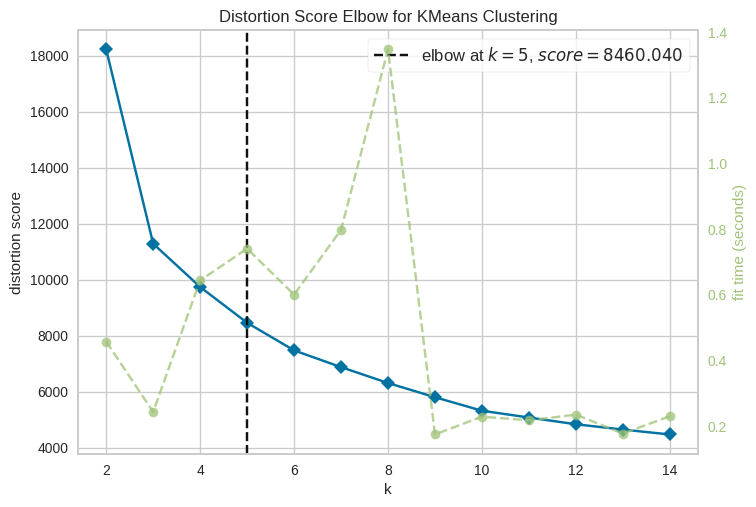

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [96]:
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2, 15))

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

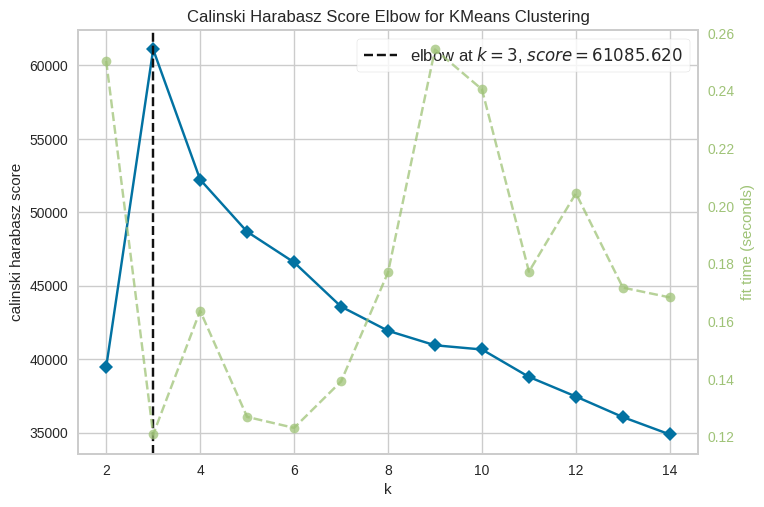

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [97]:
visualizer = KElbowVisualizer(km, k=(2, 15), metric="calinski_harabasz")

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

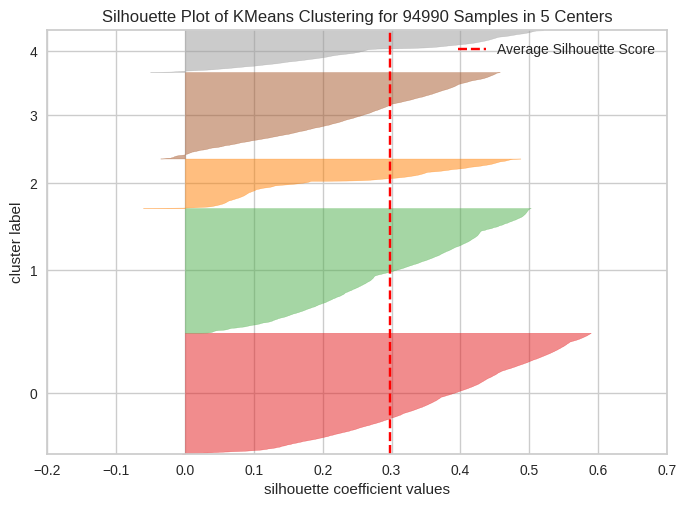

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 94990 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [98]:
km = KMeans(init="k-means++", random_state=0, n_init="auto", n_clusters=5)
visualizer = SilhouetteVisualizer(km)

visualizer.fit(X_scaled)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

#### Projection t-SNE

In [99]:
X_scaled["kmeans"] = km.labels_.astype(str)
X_scaled = X_scaled.reset_index(drop=True)
show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_scaled["kmeans"],
    title="Représentation t-NSE avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity,customer_location ; Kmeans n_cluster=5",
)

#### Interprétation

In [100]:
view_clustered_heatmap(
    X_scaled,
    birch,
    scaler,
    title="Kmeans n_clusers=5, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity,customer_location",
    height=500,
)

In [101]:
df2 = df.copy(deep=True)
df2 = pd.DataFrame(
    scaler.inverse_transform(X_scaled.loc[:, num_cols]), columns=num_cols
)
df2.reset_index(drop=True, inplace=True)
df2["kmeans"] = birch.labels_.astype(str)

show_cols_boxplots_by_col(
    df2,
    num_cols,
    "kmeans",
    title="Kmeans n_clusers=5, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity,customer_location",
    orient="v",
    h=1800,
    w=1500,
)

In [102]:
X_scaled.drop(columns="kmeans", inplace=True)

### OPTICS+DBScan
#### Evaluation

In [103]:
min_points = 2 * X_scaled.shape[1]

neighbors = NearestNeighbors(n_neighbors=min_points)
neighbors_fit = neighbors.fit(X_scaled)

distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:, 4]

kneedle = KneeLocator(
    x=range(1, len(distances) + 1),
    y=distances,
    S=1.0,
    curve="concave",
    direction="increasing",
    online=True,
)
knee_y = kneedle.knee_y
print(knee_y)

0.23962941817253763


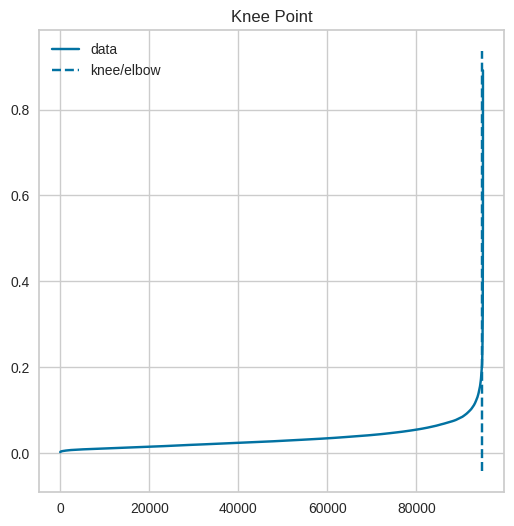

In [104]:
kneedle.plot_knee()
plt.show()

In [105]:
mem_dir = f"/tmp/optics_mem/{uuid.uuid1()}"
os.mkdir(mem_dir)

In [106]:
if "optics" in X_scaled.columns:
    X_scaled.drop(columns="optics", inplace=True)

for i in range(5, 21):
    optics = OPTICS(
        max_eps=knee_y,
        min_samples=X_scaled.shape[1] * 2,
        cluster_method="dbscan",
        eps=min(knee_y * i / 20, knee_y),
        n_jobs=-1,
        memory=mem_dir,
    ).fit(X_scaled)
    print(f"""eps={min(knee_y * i / 20, knee_y)}  ;  labels={set(optics.labels_)}""")

eps=0.05990735454313441  ;  labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, -1}
eps=0.0718888254517613  ;  labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, -1}
eps=0.08387029636038817  ;  labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, -1}
eps=0.09585176726901505  ;  labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, -1}
eps=0.10783323817764194  ;  labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,

In [107]:
optics = OPTICS(
    max_eps=knee_y,
    min_samples=X_scaled.shape[1] * 2,
    cluster_method="dbscan",
    eps=0.16123820972102595,
    n_jobs=-1,
    memory=mem_dir,
).fit(X_scaled)

#### Projection t-SNE

In [108]:
X_scaled.reset_index(drop=True, inplace=True)
X_scaled["optics"] = optics.labels_.astype(str)

show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_scaled["optics"],
    title="OPTICS+DBSCAN, avec r,f,m,weekday,review_score,<br>delivery,freight_value,photos_quantity,customer_location",
)

#### Interprétation

In [ ]:
view_clustered_heatmap(
    X_scaled,
    optics,
    scaler,
    title="OPTICS+DBSCAN, avec r,f,m,weekday,review_score,delivery,freight_value,photos_quantity,customer_location",
    height=1000,
)

Le clustering s'est fait selon most_purchased_weekday:
- Cluster 0: jeudi
- Cluster 2: mercredi
- Cluster 4: mardi
- Cluster 5: lundi
- Cluster 1: vendredi
- Cluster 3: samedi
- Cluster 6: dimanche

# Etude sur r,f,m review, weekday, delivery, freight_value, photos_quantity, customer_location, categories, payment_types

In [158]:
df = pd.read_parquet(f"{working_dir}/olist.parquet")

r = clean(
    df,
    use_features=[
        "review",
        "weekday",
        "categories",
        "delivery",
        "customer_location",
        "payment_types",
        "photos_quantity_customer",
        "freight_value",
    ],
)
df = r["data"]
scaler = r["scaler"]

featureSplitterTransformer, from_column=last_categories
featureSplitterTransformer, from_column=all_purchases_categories
featureSplitterTransformer, from_column=last_payments
featureSplitterTransformer, from_column=all_purchases_payments
last_categories
all_purchases_categories
last_payments
all_purchases_payments


In [159]:
df.reset_index(drop=True, inplace=True)
df.head()

,customer_latitude,customer_longitude,f,m,all_purchases_review_score,all_freight_value,all_cats_home_office,all_cats_health_beauty,all_cats_electronics,all_cats_clothes,all_cats_culture_leisure,all_cats_cool_stuff,all_cats_other,all_cats_construction,all_cats_food_drink,all_payments_credit_card,all_payments_cash,all_payments_voucher,all_payments_debit_card,all_payments_not_defined,most_purchased_weekday,all_delivery_delay,r
0,0.136406,0.404061,0.0,0.009603,1.00,0.006323,0.019287,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.010385,0.0,0.0,0.0,0.0,0.500000,0.423543,0.153527
1,0.133522,0.404727,0.0,0.001343,0.75,0.004368,0.000000,0.004847,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.001990,0.0,0.0,0.0,0.0,0.000000,0.423199,0.157676
2,0.081014,0.375852,0.0,0.005071,0.50,0.009074,0.010245,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.006310,0.0,0.0,0.0,0.0,0.666667,0.431732,0.741355
3,0.426723,0.378232,0.0,0.001871,0.75,0.009290,0.000000,0.000000,0.001934,0.0,0.0,0.0,0.0,0.0,0.0,0.003192,0.0,0.0,0.0,0.0,0.500000,0.402718,0.442600
4,0.134227,0.394073,0.0,0.013330,1.00,0.008900,0.000000,0.000000,0.013393,0.0,0.0,0.0,0.0,0.0,0.0,0.014409,0.0,0.0,0.0,0.0,0.166667,0.414879,0.396957


## Décomposition PCA

In [160]:
num_cols = df.select_dtypes(include=[np.number]).columns
n_components = len(df.columns)
pca = PCA(n_components=n_components)

pca.fit(df.loc[:, num_cols])
pca.explained_variance_ratio_

array([3.97208453e-01, 3.88790659e-01, 1.63980756e-01, 2.55954066e-02,
       9.10873839e-03, 3.12970588e-03, 2.62655057e-03, 1.92413544e-03,
       1.48136421e-03, 1.05416005e-03, 9.98206391e-04, 9.25424732e-04,
       7.23073823e-04, 6.81759889e-04, 5.22006594e-04, 4.59601197e-04,
       3.56343552e-04, 2.25842965e-04, 1.17529903e-04, 7.93443549e-05,
       7.54149935e-06, 3.39587098e-06, 2.05174982e-36])

In [161]:
show_pca_variance_graph(pca)

Les 46 premières composantes expliquent 98.8% de la variance totale.

In [162]:
import itertools


def show_pca_correlation_graph2(pca, x_y, features, w=800, h=600):
    colors_cycle = itertools.cycle(px.colors.qualitative.Dark24)

    x, y = x_y

    fig = go.Figure()
    fig.add_shape(
        type="circle",
        xref="x",
        yref="y",
        x0=-1,
        y0=-1,
        x1=1,
        y1=1,
        line_color="Black",
    )

    for i in range(0, pca.components_.shape[1]):
        color = next(colors_cycle)
        fig.add_annotation(
            x=pca.components_[x, i],
            y=pca.components_[y, i],
            xref="x",
            yref="y",
            showarrow=True,
            axref="x",
            ayref="y",
            ax=0,
            ay=0,
            arrowhead=4,
            arrowwidth=2,
            arrowcolor=color,
            font=dict(color=color, size=12),
        )
        fig.add_trace(
            go.Scatter(
                x=[pca.components_[x, i]] + 0.05 * pca.components_[x, i],
                y=[pca.components_[y, i]] + 0.05 * pca.components_[y, i],
                text=[features[i]],
                mode="text",
                marker=dict(color=color),
                name=features[i],
            ),
        )

    fig.update_layout(
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99,
        ),
        width=w,
        height=h,
    )
    fig.update_xaxes(range=[-1.1, 1.1], title=dict(text=f"F{x+1}"))
    fig.update_yaxes(range=[-1.1, 1.1], title=dict(text=f"F{y+1}"))

    fig.for_each_trace(lambda t: t.update(textfont_color=t.marker.color))
    fig.update_yaxes(
        scaleanchor="x",
        scaleratio=1,
    )
    fig.show()

In [163]:
show_pca_correlation_graph(pca, (0, 1), num_cols, w=1500, h=1000)

In [164]:
show_pca_correlation_graph(pca, (2, 3), num_cols, w=1500, h=1000)

In [165]:
show_pca_correlation_graph(pca, (4, 5), num_cols, w=1500, h=1000)

In [166]:
pca = PCA(n_components=6)

pca.fit(df.loc[:, num_cols])
pca.explained_variance_ratio_

array([0.39720845, 0.38879066, 0.16398076, 0.02559541, 0.00910874,
       0.00312971])

In [167]:
X_pca = pd.DataFrame(
    pca.transform(df.loc[:, num_cols]),
    columns=["pca1", "pca2", "pca3", "pca4", "pca5", "pca6"],
)

In [168]:
X_pca

,pca1,pca2,pca3,pca4,pca5,pca6
0,-0.148789,-0.170411,-0.174520,-0.024313,-0.008417,0.023090
1,-0.268882,0.375449,-0.169623,-0.029411,-0.010015,0.017781
2,0.355130,0.015609,0.402523,-0.098640,-0.018896,0.030193
3,0.053241,-0.011181,0.113267,0.191921,0.179314,0.016553
4,-0.353954,0.089272,0.072197,-0.032988,-0.002110,0.017119
...,...,...,...,...,...,...
94985,-0.136678,-0.167291,0.290524,0.240173,-0.007318,-0.105499
94986,0.366429,-0.399751,0.025135,0.160126,-0.025262,0.028820
94987,-0.347211,0.089507,0.461695,0.017334,0.190224,-0.029360
94988,-0.252804,-0.040626,-0.162393,0.046548,-0.055872,-0.008163


In [169]:
c = df["most_purchased_weekday"].astype(str)

In [170]:
show_scatter_graph(
    x=X_pca["pca1"],
    y=X_pca["pca2"],
    title="Projection sur les axes PCA 1 et 2",
    w=1000,
    h=1000,
)

In [171]:
show_scatter_graph(
    x=X_pca["pca3"],
    y=X_pca["pca4"],
    title="Projection sur axes PCA 3 et 4",
    w=1000,
    h=1000,
)

In [172]:
show_scatter_graph(
    x=X_pca["pca5"],
    y=X_pca["pca6"],
    title="Projection sur  axes PCA 5 et 6",
    w=1000,
    h=1000,
)

## Projection t-NSE

In [173]:
if os.path.exists(
    f"{working_dir}/X_embedded_pca_rfm_review_weekday_delivery_freight_value_photos_quantity_customer_location_categories_payment_types.npy"
):
    X_embedded = np.load(
        f"{working_dir}/X_embedded_pca_rfm_review_weekday_delivery_freight_value_photos_quantity_customer_location_categories_payment_types.npy"
    )
else:
    tsne = TSNE(n_components=2, random_state=0)
    X_embedded = tsne.fit_transform(X_scaled)
    np.save(
        f"{working_dir}/X_embedded_pca_rfm_review_weekday_delivery_freight_value_photos_quantity_customer_location_categories_payment_types.npy",
        X_embedded,
    )

In [174]:
show_scatter_graph(
    X_embedded[:, 0],
    X_embedded[:, 1],
    title="""Représentation t-NSE avec r,f,m review, weekday, delivery, freight_value,<br>photos_quantity, customer_location, categories, payment_types""",
    w=1000,
)

## Clustering
### Birch
#### Evaluation

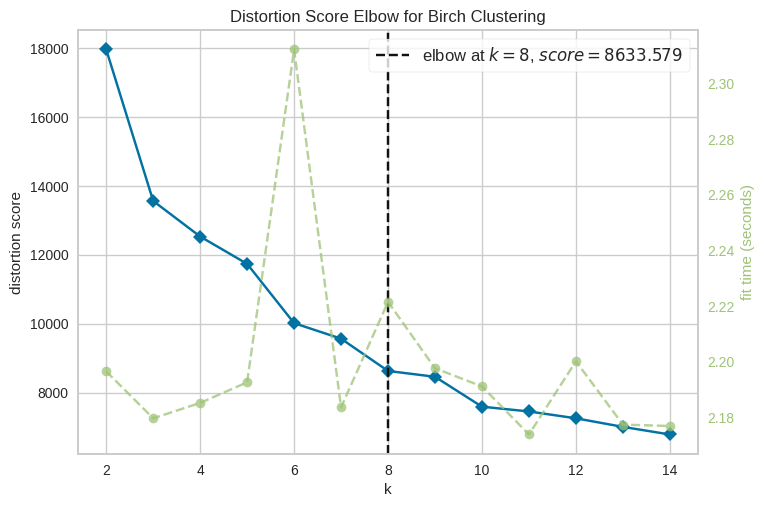

<Axes: title={'center': 'Distortion Score Elbow for Birch Clustering'}, xlabel='k', ylabel='distortion score'>

In [175]:
birch = Birch(threshold=0.1)
visualizer = KElbowVisualizer(birch, k=(2, 15))

visualizer.fit(X_pca)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

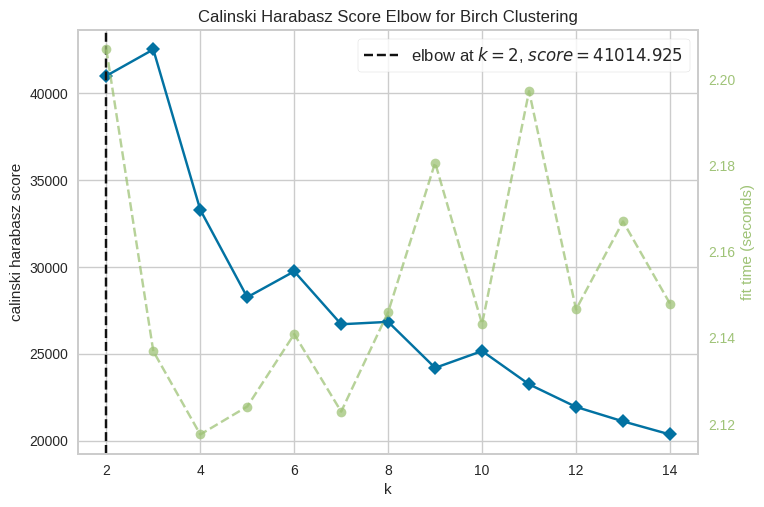

<Axes: title={'center': 'Calinski Harabasz Score Elbow for Birch Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [176]:
visualizer = KElbowVisualizer(birch, k=(2, 15), metric="calinski_harabasz")

visualizer.fit(X_pca)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

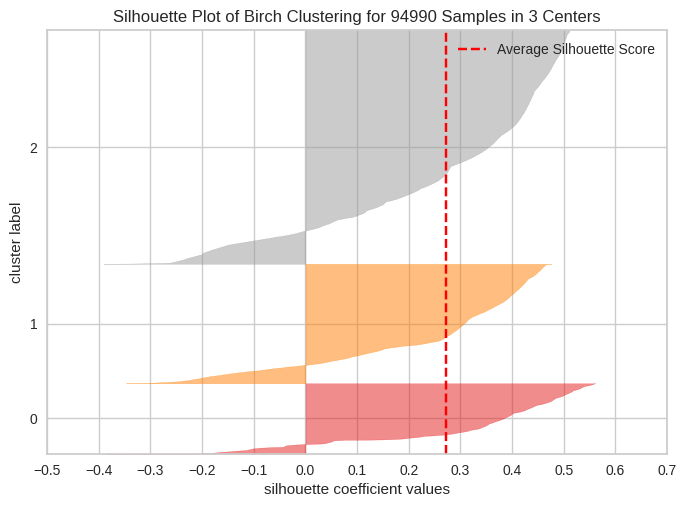

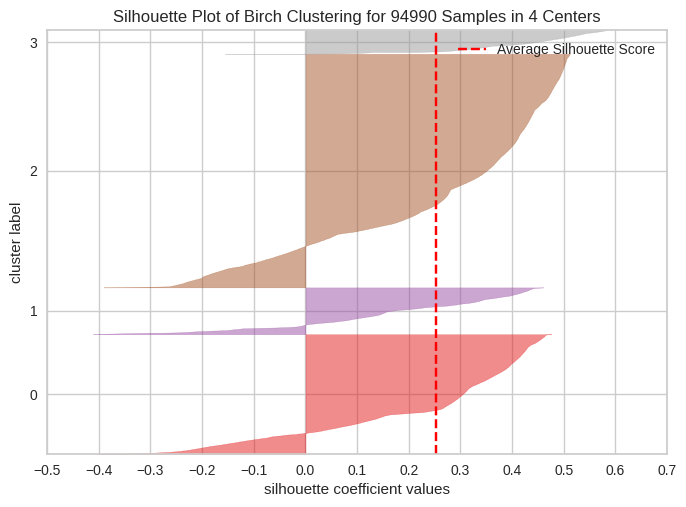

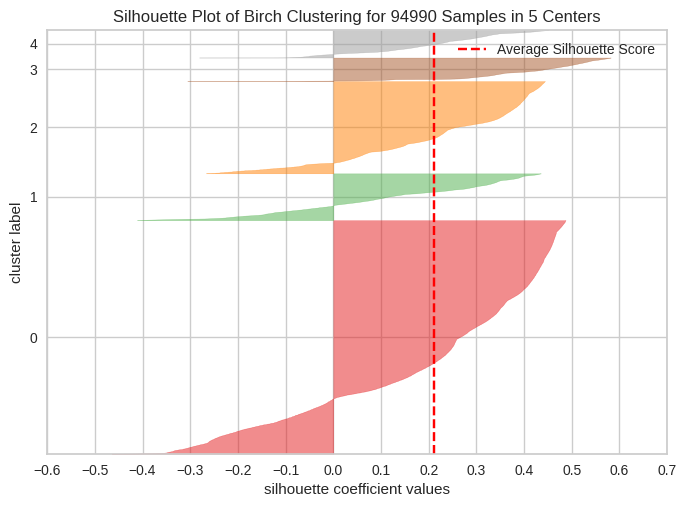

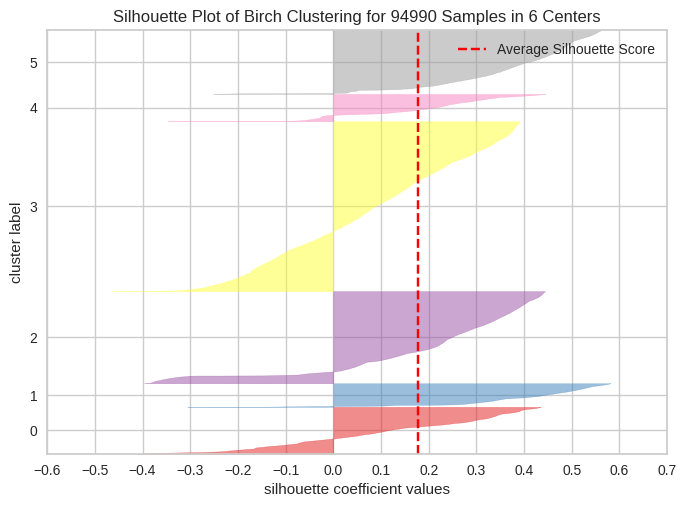

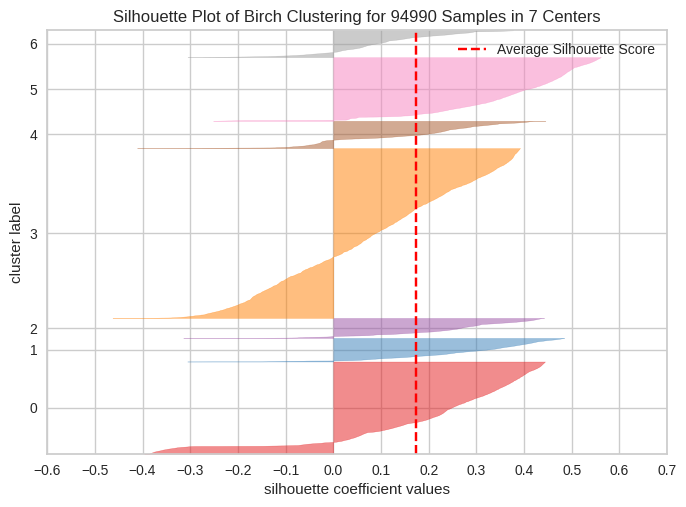

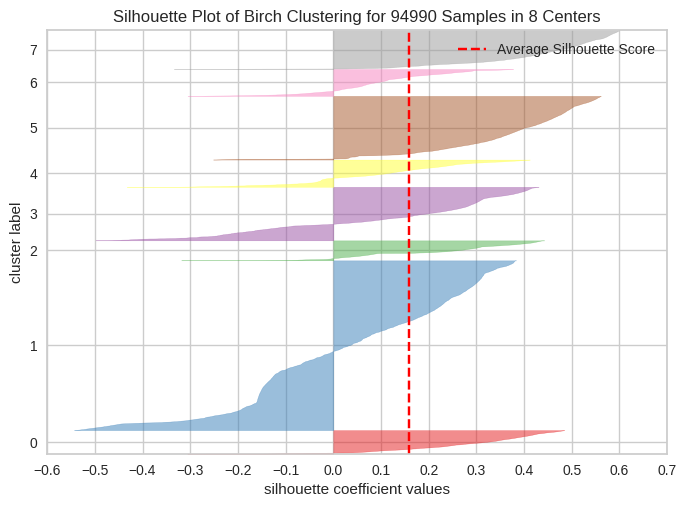

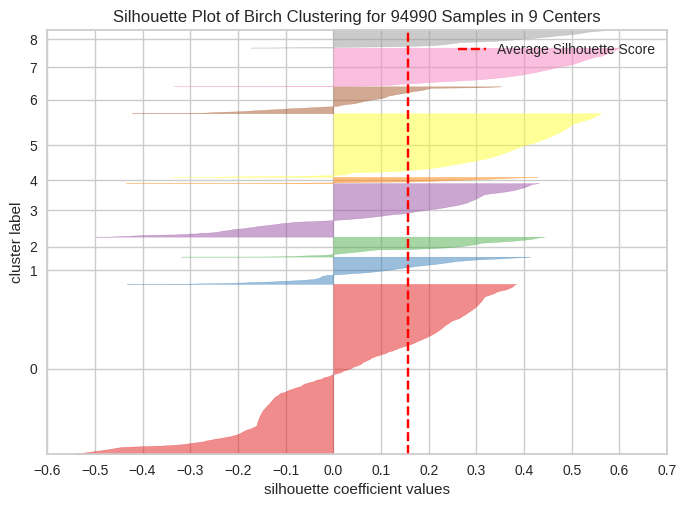

In [177]:
for n_clusters in range(3, 10):
    birch = Birch(threshold=0.1, n_clusters=n_clusters)
    visualizer = SilhouetteVisualizer(birch)

    visualizer.fit(X_pca)  # Fit the data to the visualizer
    visualizer.poof()  # Draw/show/poof the data

#### Projection t-SNE

In [132]:
X_pca["birch"] = birch.labels_.astype(str)

show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_pca["birch"],
    title="Birch, n_clusters=5, avec r,f,m review, weekday, delivery, freight_value,<br>photos_quantity, customer_location, categories, payment_types",
)

#### Projections PCA

In [133]:
show_scatter_graph(
    x=X_pca["pca1"],
    y=X_pca["pca2"],
    colors=X_pca["birch"],
    title="Birch, n_clusters=5, avec r,f,m review, weekday, delivery, freight_value,<br>photos_quantity, customer_location, categories, payment_types",
)

Dans les 2 premiers axes PCA1 et PCA2, on voit:
- cluster 2: clients de fin de semaine (vendredi au dimanche) avec review_score >3
- cluster 0: clients de début de semaine (lundi au jeudi) avec review_score >3
- cluster 4: client avec review_score>3
- cluster 3: clients du lundi au jeudi avec review_score <3
- cluster 1: clients du mardi au dimanche avec review_score<3

Explication pour les jours:

In [134]:
show_scatter_graph(
    x=X_pca["pca1"],
    y=X_pca["pca2"],
    colors=df["most_purchased_weekday"],
    title="Projection PCA selon les 2 premiers axes en fonction du jour de la semaine",
)

In [135]:
df_inv = pd.DataFrame(scaler.inverse_transform(df), columns=num_cols)
df_tmp = X_pca.loc[:, ["pca1", "pca2"]]
df_tmp["review_score"] = df_inv["all_purchases_review_score"]
px.scatter(df_tmp, x="pca1", y="pca2", color="review_score")

show_scatter_graph(
    x=X_pca["pca3"],
    y=X_pca["pca4"],
    colors=X_pca["birch"],
    title="Birch, n_clusters=5, avec r,f,m, review, weekday, delivery, freight_value,<br>photos_quantity, customer_location, categories, payment_types",
)

Dans les axes PCA3 et PCA4, on voit:
- cluster 4: PCA3 <= 0.17, ce qui correspond à r<= 354 jours
- cluster 2: PCA3 >= 0, ce qui correnspond à r>= 236 jours

Pour le calcul du r à partir de pca3<=0.17 (sachant que r et pca3 évoluent exactement dans le même sens):

In [136]:
pd.DataFrame(
    scaler.inverse_transform(
        pca.inverse_transform(
            X_pca.loc[
                (X_pca["pca3"] < 0.1705) & (X_pca["pca3"] > 0.1695),
                ["pca1", "pca2", "pca3", "pca4", "pca5", "pca6"],
            ]
        )
    ),
    columns=num_cols,
)["r"].mean()

361.5665722867329

Pour le calcul du r à partir de pca3>=0 (sachant que r et pca3 évoluent exactement dans le même sens):

In [137]:
pd.DataFrame(
    scaler.inverse_transform(
        pca.inverse_transform(
            X_pca.loc[
                (X_pca["pca3"] < 0.0005) & (X_pca["pca3"] > -0.0005),
                ["pca1", "pca2", "pca3", "pca4", "pca5", "pca6"],
            ]
        )
    ),
    columns=num_cols,
)["r"].mean()

237.39423787488082

In [138]:
show_scatter_graph(
    x=X_pca["pca5"],
    y=X_pca["pca6"],
    colors=X_pca["birch"],
    title="Birch, n_clusters=5, avec r,f,m review, weekday, delivery, freight_value,<br>photos_quantity, customer_location, categories, payment_types",
)

#### Interprétation

Avec Birch et 5 clusters et les 4 premiers axes de la PCA, on a des clusters définis:
- cluster 4: clients de fin de semaine (vendredi au dimanche) avec review_score >3 et une récence r<= 354 jours
- cluster 0: clients de début de semaine (lundi au jeudi) avec review_score >3
- cluster 2: client avec review_score>3 et une récence r>= 236 jours
- cluster 3: clients du lundi au jeudi avec review_score <3
- cluster 1: clients du jeudi au dimanche avec review_score<3

In [139]:
X_pca.drop(columns="birch", inplace=True)

### Kmeans
#### Evaluation

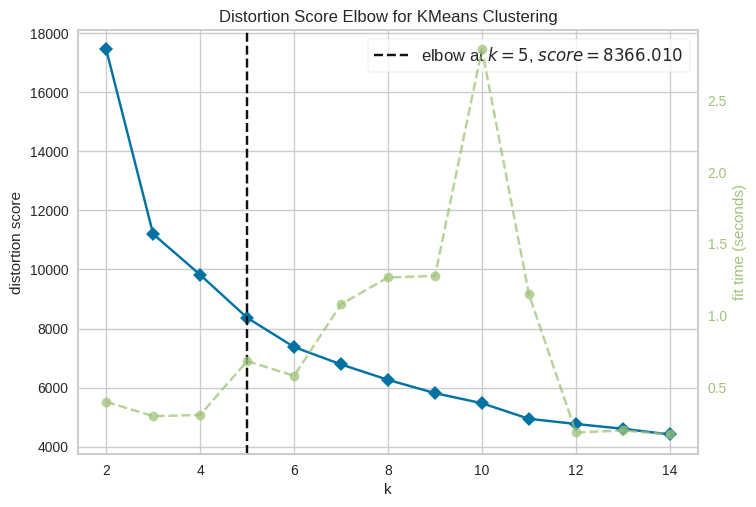

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [140]:
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2, 15))

visualizer.fit(X_pca)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

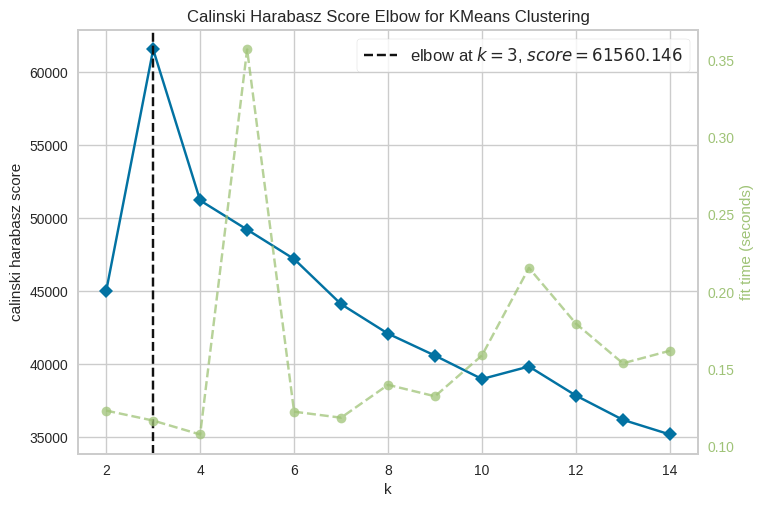

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [141]:
visualizer = KElbowVisualizer(km, k=(2, 15), metric="calinski_harabasz")

visualizer.fit(X_pca)  # Fit the data to the visualizer
visualizer.poof()  # Draw/show/poof the data

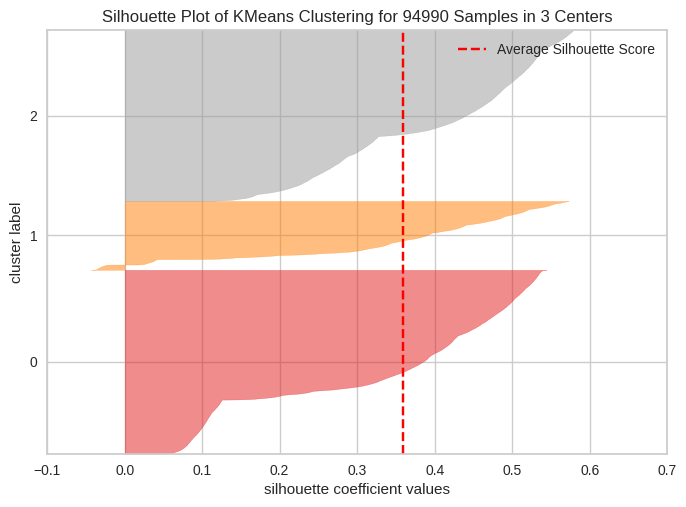

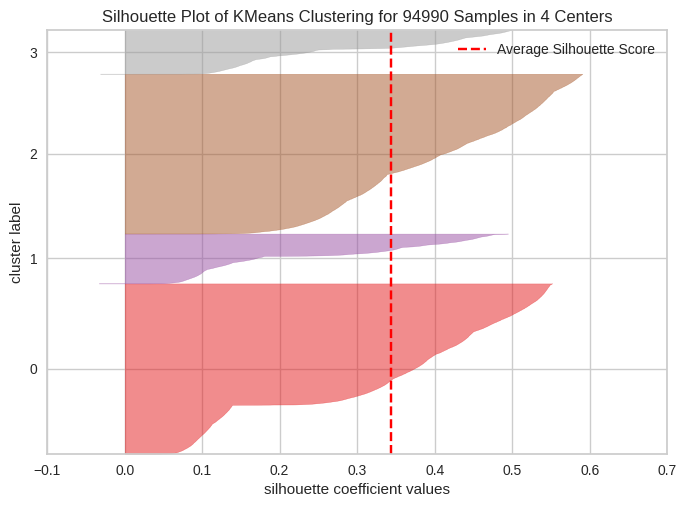

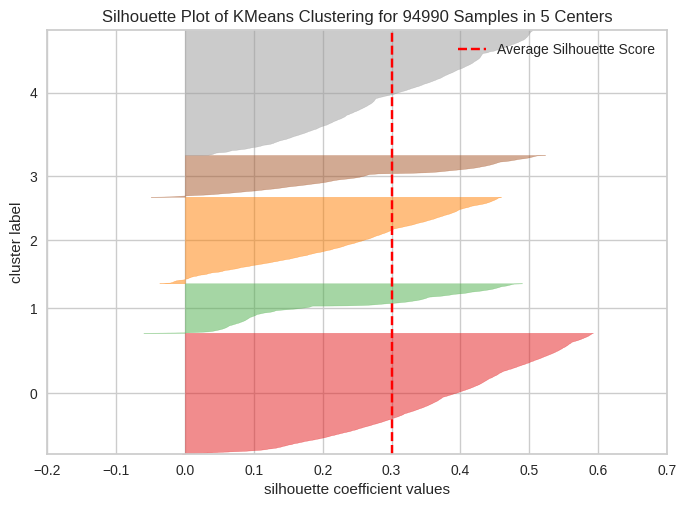

In [142]:
for n_clusters in range(3, 6):
    km = KMeans(init="k-means++", random_state=0, n_init="auto", n_clusters=n_clusters)
    visualizer = SilhouetteVisualizer(km)

    visualizer.fit(X_pca)  # Fit the data to the visualizer
    visualizer.poof()  # Draw/show/poof the data

In [180]:
km = KMeans(init="k-means++", random_state=0, n_init="auto", n_clusters=5)
km.transform(X_pca)

KMeans(n_clusters=5, n_init='auto', random_state=0)

#### Projection t-SNE

In [181]:
X_pca["kmeans"] = km.labels_.astype(str)

show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_pca["kmeans"],
    title="Kmeans, n_clusters=5, avec r,f,m review, weekday, delivery, freight_value,<br>photos_quantity, customer_location, categories, payment_types",
)

#### Projections PCA

In [182]:
show_scatter_graph(
    x=X_pca["pca1"],
    y=X_pca["pca2"],
    colors=X_pca["kmeans"],
    title="Kmeans, n_clusters=5, avec r,f,m review, weekday, delivery, freight_value,<br>photos_quantity, customer_location, categories, payment_types",
)

La projection su les axes PCA1 et PCA2 nous indique:
- cluster 0 : clients qui achètent du vendredi au dimanche avec review_score>=3.5 
- cluster 4 : clients qui achètent du lundi au jeudi avec review_score>=3.5
- cluster 3 : clients qui achètent du lundi au mercredi avec review_score < 3
- cluster 0 : clients qui achètent du vendredi au dimanche avec review_score >=3.5
- cluster 2 : clients qui achètent du lundi au vendredi avec review_score>=3.5

In [183]:
show_scatter_graph(
    x=X_pca["pca3"],
    y=X_pca["pca4"],
    colors=X_pca["kmeans"],
    title="Kmeans, n_clusters=5, avec r,f,m review, weekday, delivery, freight_value,<br>photos_quantity, customer_location, categories, payment_types",
)

Dans les axes PCA3 et PCA4, on voit:
- cluster 2: PCA3 <= 0.0042, ce qui correspond à r<= 240 jours
- cluster 4: PCA3 >= 0.003, ce qui correnspond à r>= 263 jours

In [185]:
pd.DataFrame(
    scaler.inverse_transform(
        pca.inverse_transform(
            X_pca.loc[
                (X_pca["pca3"] < 0.00425) & (X_pca["pca3"] > 0.00415),
                ["pca1", "pca2", "pca3", "pca4", "pca5", "pca6"],
            ]
        )
    ),
    columns=num_cols,
)["r"].mean()

240.0142525217002

In [188]:
pd.DataFrame(
    scaler.inverse_transform(
        pca.inverse_transform(
            X_pca.loc[
                (X_pca["pca3"] > 0.0295) & (X_pca["pca3"] < 0.0305),
                ["pca1", "pca2", "pca3", "pca4", "pca5", "pca6"],
            ]
        )
    ),
    columns=num_cols,
)["r"].mean()

263.3193151980975

In [189]:
show_scatter_graph(
    x=X_pca["pca5"],
    y=X_pca["pca6"],
    colors=X_pca["kmeans"],
    title="Kmeans, n_clusters=5, avec r,f,m review, weekday, delivery, freight_value,<br>photos_quantity, customer_location, categories, payment_types",
)

#### Interprétation

Avec KMeans et 5 clusters et les 4 premiers axes de la PCA, on a des clusters définis:
- cluster 0 : clients qui achètent du vendredi au dimanche avec review_score>=3.5
- cluster 4 : clients qui achètent du lundi au jeudi avec review_score>=3.5  et r>= 263 jours
- cluster 3 : clients qui achètent du lundi au mercredi avec review_score < 3
- cluster 0 : clients qui achètent du vendredi au dimanche avec review_score >=3.5
- cluster 2 : clients qui achètent du lundi au vendredi avec review_score>=3.5 et r<= 240 jours

In [190]:
X_pca.drop(columns="kmeans", inplace=True)

### OPTICS+DBScan
#### Evaluation

In [150]:
min_points = 2 * X_pca.shape[1]

neighbors = NearestNeighbors(n_neighbors=min_points)
neighbors_fit = neighbors.fit(X_pca)

distances, indices = neighbors_fit.kneighbors(X_pca)
distances = np.sort(distances, axis=0)
distances = distances[:, 4]

kneedle = KneeLocator(
    x=range(1, len(distances) + 1),
    y=distances,
    S=1.0,
    curve="concave",
    direction="increasing",
    online=True,
)
knee_y = kneedle.knee_y
print(knee_y)

0.19363773552265948


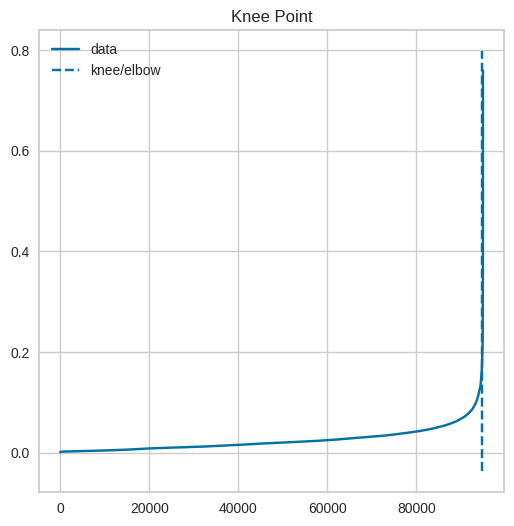

In [151]:
kneedle.plot_knee()
plt.show()

In [191]:
mem_dir = f"/tmp/optics_mem/{uuid.uuid1()}"
os.mkdir(mem_dir)

In [201]:
if "optics" in X_pca.columns:
    X_pca.drop(columns="optics", inplace=True)

for i in range(5, 21):
    optics = OPTICS(
        max_eps=knee_y,
        min_samples=X_scaled.shape[1] * 2,
        cluster_method="dbscan",
        eps=min(knee_y * i / 20, knee_y),
        n_jobs=-1,
        memory=mem_dir,
    ).fit(X_scaled)
    print(f"""eps={min(knee_y * i / 20, knee_y)}  ;  labels={set(optics.labels_)}""")

eps=0.04840943388066487  ;  labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, -1}
eps=0.05809132065679784  ;  labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, -1}
eps=0.06777320743293082  ;  labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, -1}
eps=0.0774550942090638  ;  labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, -1}
eps=0.08713698098519676  ;  labels={0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,

In [202]:
optics = OPTICS(
    max_eps=knee_y,
    min_samples=X_scaled.shape[1] * 2,
    cluster_method="dbscan",
    eps=0.1452283016419946,
    n_jobs=-1,
    memory=mem_dir,
).fit(X_scaled)

#### Projection t-NSE

In [203]:
set(optics.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [205]:
X_pca["optics"] = optics.labels_.astype(str)

show_scatter_graph(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    colors=X_pca["optics"],
    title="OPTICS+DBSCAN, avec r,f,m review, weekday, delivery, freight_value,<br>photos_quantity, customer_location, categories, payment_types",
)

In [206]:
show_scatter_graph(
    x=X_pca["pca1"],
    y=X_pca["pca2"],
    colors=X_pca["optics"],
    title="OPTICS+DBSCAN, avec r,f,m review, weekday, delivery, freight_value,<br>photos_quantity, customer_location, categories, payment_types",
)

#### Interprétation

- Cluster 2: clients du lundi
- Cluster 5: clients du mardi review_score>1
- Cluster 6: clients du mardi review_score=1
- Cluster 7: clients du mercredi
- Cluster 0: clients du jeudi review_score>1
- Cluster 1: clients du jeudi review_score=1
- Cluster 3: clients du vendredi review_score<=1.5
- Cluster 4: clients du vendredi review_score>1.5
- Cluster 8: clients du samedi
- Cluster 9: clients du dimanche